In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import sys
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import scipy.stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC
from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 10})
plt.rc('font', family='serif')

####################################################################################################################################################################################

## [0] Load in Hs from *TopDis (spacer length = 4)* for INDELs, and get top 10 HTs & top 10 SSRs

####################################################################################################################################################################################

In [4]:
#load in INDELs
all_homoplasic_INDELs = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/INDEL homoplasies/homoplasy_count_across_lineages_spacer_4.pkl')

In [5]:
all_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,1,2,3,4A,4B,4C,5,6,total,num_isolates
47371,4408100,GC,G,Antibiotic Resistance,gid,Rv3919c,103,del,frameshift,35,...,41.0,27.0,51.0,43.0,11.0,29.0,0.0,0.0,202.0,388
47365,4408087,CG,C,Antibiotic Resistance,gid,Rv3919c,116,del,frameshift,39,...,23.0,11.0,35.0,33.0,10.0,18.0,0.0,0.0,130.0,212
47313,4407851,GC,G,Antibiotic Resistance,gid,Rv3919c,352,del,frameshift,118,...,21.0,9.0,40.0,20.0,6.0,19.0,0.0,0.0,115.0,182
25151,2288850,A,ACC,Antibiotic Resistance,pncA,Rv2043c,392,ins,frameshift,131,...,1.0,14.0,6.0,3.0,6.0,2.0,0.0,0.0,32.0,48
47315,4407851,G,GC,Antibiotic Resistance,gid,Rv3919c,352,ins,frameshift,118,...,5.0,1.0,12.0,5.0,7.0,1.0,0.0,0.0,31.0,52


In [6]:
np.shape(all_homoplasic_INDELs)

(46306, 22)

Note - SNPs & INDELs with homoplasy score $ = 0$ were dropped from DataFrames

#### mark *mmpR* (Rv0678) as an Antibiotic Resistance gene

In [7]:
all_homoplasic_INDELs.loc[all_homoplasic_INDELs['gene_id'] == 'Rv0678', 'gene_category'] = 'Antibiotic Resistance'
all_homoplasic_INDELs.loc[all_homoplasic_INDELs['gene_id'] == 'Rv0678', 'gene_name'] = 'mmpR'

all_homoplasic_INDELs.loc[all_homoplasic_INDELs['gene_id'] == 'Rv3696c', 'gene_category'] = 'Antibiotic Resistance'

####################################################################################################################################################################################

## [1] Separate INDELs into those occcurring in HT regions, SSR regions and those not in either

####################################################################################################################################################################################

### [1.1] HT

In [8]:
homopolymeric_regions_from_Luca = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/comparison_with_homopolymeric_regions/homopolymer regions from Luca/list_homopolymers_7bpmore_pure.csv')

**Note 1:** Luca's scheme starts at -1bp relative to the HT track since that's where variants are usually called

**Note 2:** two HT regions in *PPE13* are located right next to eachother, change chromEnd position of the *TTTTTTTT* HT so we don't double count indels

In [9]:
homopolymeric_regions_from_Luca[homopolymeric_regions_from_Luca.gene_name == 'PPE13']

,Chromosome,chromStart,chromEnd,polyNT,locus_tag,gene_name
80,NC_000962.3,976889,976897,TTTTTTTT,Rv0878c,PPE13
103,NC_000962.3,976897,976906,GGGGGGGGG,Rv0878c,PPE13


In [10]:
homopolymeric_regions_from_Luca.loc[80,'chromEnd'] = 976896

create a set of all Reference Positions that occur within a Homopolymeric Tract

In [11]:
all_HT_ref_postions = []
for HT_i_start, HT_i_end in zip(homopolymeric_regions_from_Luca.chromStart, homopolymeric_regions_from_Luca.chromEnd):
    
    HT_i_ref_positions = range(HT_i_start, HT_i_end+1)
    all_HT_ref_postions = all_HT_ref_postions + HT_i_ref_positions
    
all_HT_ref_postions = set(all_HT_ref_postions)

In [12]:
len(all_HT_ref_postions)

1160

### [1.2] SSR

In [13]:
SSR_H37Rv_df = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/simple_sequence_repeat_regions/SSR_H37Rv_2-6bp_at_least_3_repeats.pkl')

In [14]:
SSR_H37Rv_df.head()

,H37Rv_start,H37Rv_end,motif,repeats
0,561,569,CGC,3
1,562,570,GCC,3
2,643,648,AC,3
3,1121,1126,GC,3
4,1408,1413,CA,3


In [15]:
H37Rv_SSR_positions_list = []
for SSR_i_start, SSR_i_end in zip(SSR_H37Rv_df.H37Rv_start, SSR_H37Rv_df.H37Rv_end):
    
    SSR_i_H37Rv_coords = list(np.arange(SSR_i_start, SSR_i_end + 1))
    
    H37Rv_SSR_positions_list = H37Rv_SSR_positions_list + SSR_i_H37Rv_coords
    
H37Rv_SSR_positions_list = list(set(H37Rv_SSR_positions_list)) # remove duplicate positions from overlapping SSR regions

start at -1bp relative to the SSR track since that's where variants are usually called

In [16]:
SSR_H37Rv_df.loc[:, 'H37Rv_start'] = SSR_H37Rv_df.H37Rv_start - 1

In [17]:
SSR_H37Rv_df.head()

,H37Rv_start,H37Rv_end,motif,repeats
0,560,569,CGC,3
1,561,570,GCC,3
2,642,648,AC,3
3,1120,1126,GC,3
4,1407,1413,CA,3


**Note:** use this list when sorting INDEL variants that occur within an SSR region

In [18]:
H37Rv_SSR_positions_list = []
for SSR_i_start, SSR_i_end in zip(SSR_H37Rv_df.H37Rv_start, SSR_H37Rv_df.H37Rv_end):
    
    SSR_i_H37Rv_coords = list(np.arange(SSR_i_start, SSR_i_end + 1))
    
    H37Rv_SSR_positions_list = H37Rv_SSR_positions_list + SSR_i_H37Rv_coords
    
H37Rv_SSR_positions_list = list(set(H37Rv_SSR_positions_list)) # remove duplicate positions from overlapping SSR regions

In [19]:
len(H37Rv_SSR_positions_list)

112673

set of all Reference Positions that occur within a SSR region (including positions at -1bp relative to SSR region)

In [20]:
H37Rv_SSR_positions = set(H37Rv_SSR_positions_list)

In [21]:
len(H37Rv_SSR_positions)

112673

### [1.3] Annotate each INDEL based on whether it is in a SSR or HT or other

iterate through all INDELs and figure out which occur in SSR and those that don't

In [22]:
repeat_region_list = []
for indel_i_pos in all_homoplasic_INDELs.pos:
    
    if indel_i_pos in all_HT_ref_postions:
        repeat_region_list.append('HT')
    
    elif indel_i_pos in H37Rv_SSR_positions:
        repeat_region_list.append('SSR')
        
    else:
        repeat_region_list.append('no')
        
all_homoplasic_INDELs.loc[:,'repeat_region'] = repeat_region_list

In [23]:
all_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,2,3,4A,4B,4C,5,6,total,num_isolates,repeat_region
47371,4408100,GC,G,Antibiotic Resistance,gid,Rv3919c,103,del,frameshift,35,...,27.0,51.0,43.0,11.0,29.0,0.0,0.0,202.0,388,no
47365,4408087,CG,C,Antibiotic Resistance,gid,Rv3919c,116,del,frameshift,39,...,11.0,35.0,33.0,10.0,18.0,0.0,0.0,130.0,212,no
47313,4407851,GC,G,Antibiotic Resistance,gid,Rv3919c,352,del,frameshift,118,...,9.0,40.0,20.0,6.0,19.0,0.0,0.0,115.0,182,SSR
25151,2288850,A,ACC,Antibiotic Resistance,pncA,Rv2043c,392,ins,frameshift,131,...,14.0,6.0,3.0,6.0,2.0,0.0,0.0,32.0,48,no
47315,4407851,G,GC,Antibiotic Resistance,gid,Rv3919c,352,ins,frameshift,118,...,1.0,12.0,5.0,7.0,1.0,0.0,0.0,31.0,52,SSR


In [24]:
all_homoplasic_INDELs.shape

(46306, 23)

### create a table of INDELs for Max to check Illumina & PacBio for

In [25]:
# sort by highest Hs
homoplasic_INDELs_max = all_homoplasic_INDELs.sort_values(by='total',ascending=False)

In [26]:
homoplasic_INDELs_max.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,2,3,4A,4B,4C,5,6,total,num_isolates,repeat_region
33901,3131469,T,TTGTCGGCGA,Antigen,Rv2823c,Rv2823c,305,ins,inframe,102,...,377.0,183.0,351.0,367.0,88.0,5.0,5.0,1534.0,5093,no
20085,1894300,G,GGTCTTGCCGC,Non-Essential,Rv1668c,Rv1668c,1043,ins,frameshift,348,...,306.0,205.0,288.0,313.0,210.0,11.0,5.0,1488.0,12599,no
10886,968426,A,AGCCGGGTTG,PE/PPE,PE_PGRS15,Rv0872c,1819,ins,inframe,607,...,345.0,118.0,275.0,302.0,147.0,3.0,3.0,1331.0,2943,no
22757,2137521,A,ACTCCGATCAC,Non-Essential,Rv1888c,Rv1888c,559,ins,frameshift,187,...,278.0,185.0,261.0,287.0,1.0,5.0,4.0,1155.0,12566,no
11027,976897,T,TG,PE/PPE,PPE13,Rv0878c,1307,ins,frameshift,436,...,361.0,139.0,249.0,173.0,156.0,0.0,0.0,1126.0,3745,HT


get table of top non-HT INDELs across the genome

In [27]:
homoplasic_INDELs_max = homoplasic_INDELs_max[homoplasic_INDELs_max.repeat_region != 'HT']

In [28]:
homoplasic_INDELs_max.shape

(45976, 23)

In [29]:
homoplasic_INDELs_max.head(n=10)

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,2,3,4A,4B,4C,5,6,total,num_isolates,repeat_region
33901,3131469,T,TTGTCGGCGA,Antigen,Rv2823c,Rv2823c,305,ins,inframe,102,...,377.0,183.0,351.0,367.0,88.0,5.0,5.0,1534.0,5093,no
20085,1894300,G,GGTCTTGCCGC,Non-Essential,Rv1668c,Rv1668c,1043,ins,frameshift,348,...,306.0,205.0,288.0,313.0,210.0,11.0,5.0,1488.0,12599,no
10886,968426,A,AGCCGGGTTG,PE/PPE,PE_PGRS15,Rv0872c,1819,ins,inframe,607,...,345.0,118.0,275.0,302.0,147.0,3.0,3.0,1331.0,2943,no
22757,2137521,A,ACTCCGATCAC,Non-Essential,Rv1888c,Rv1888c,559,ins,frameshift,187,...,278.0,185.0,261.0,287.0,1.0,5.0,4.0,1155.0,12566,no
14481,1313337,A,AG,None,Rv1179c_pks3,Rv1179c_Rv1180,None,ins,frameshift,None,...,195.0,65.0,129.0,124.0,104.0,0.0,1.0,674.0,16070,no
35080,3296371,G,GCCGCGGC,Non-Essential,pks15,Rv2947c,1470,ins,frameshift,490,...,313.0,197.0,0.0,0.0,1.0,9.0,0.0,649.0,6145,no
39829,3794867,C,CCA,Non-Essential,dxs2,Rv3379c,1,ins,frameshift,1,...,300.0,66.0,1.0,0.0,1.0,5.0,4.0,427.0,8059,no
3014,234496,C,CGT,Non-Essential,Rv0197,Rv0197,2266,ins,frameshift,756,...,111.0,28.0,49.0,116.0,51.0,5.0,1.0,401.0,21397,no
752,55540,G,GCCGCCGCCT,Non-Essential,ponA1,Rv0050,1878,ins,inframe,626,...,272.0,0.0,0.0,0.0,0.0,6.0,5.0,397.0,2238,SSR
40368,3842463,TA,T,PE/PPE,PPE57,Rv3425,225,del,frameshift,75,...,393.0,1.0,0.0,0.0,0.0,0.0,0.0,394.0,2651,no


cut down to top 10 Hs INDELs

In [30]:
homoplasic_INDELs_max = homoplasic_INDELs_max.head(n=10)

In [31]:
homoplasic_INDELs_max

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,2,3,4A,4B,4C,5,6,total,num_isolates,repeat_region
33901,3131469,T,TTGTCGGCGA,Antigen,Rv2823c,Rv2823c,305,ins,inframe,102,...,377.0,183.0,351.0,367.0,88.0,5.0,5.0,1534.0,5093,no
20085,1894300,G,GGTCTTGCCGC,Non-Essential,Rv1668c,Rv1668c,1043,ins,frameshift,348,...,306.0,205.0,288.0,313.0,210.0,11.0,5.0,1488.0,12599,no
10886,968426,A,AGCCGGGTTG,PE/PPE,PE_PGRS15,Rv0872c,1819,ins,inframe,607,...,345.0,118.0,275.0,302.0,147.0,3.0,3.0,1331.0,2943,no
22757,2137521,A,ACTCCGATCAC,Non-Essential,Rv1888c,Rv1888c,559,ins,frameshift,187,...,278.0,185.0,261.0,287.0,1.0,5.0,4.0,1155.0,12566,no
14481,1313337,A,AG,None,Rv1179c_pks3,Rv1179c_Rv1180,None,ins,frameshift,None,...,195.0,65.0,129.0,124.0,104.0,0.0,1.0,674.0,16070,no
35080,3296371,G,GCCGCGGC,Non-Essential,pks15,Rv2947c,1470,ins,frameshift,490,...,313.0,197.0,0.0,0.0,1.0,9.0,0.0,649.0,6145,no
39829,3794867,C,CCA,Non-Essential,dxs2,Rv3379c,1,ins,frameshift,1,...,300.0,66.0,1.0,0.0,1.0,5.0,4.0,427.0,8059,no
3014,234496,C,CGT,Non-Essential,Rv0197,Rv0197,2266,ins,frameshift,756,...,111.0,28.0,49.0,116.0,51.0,5.0,1.0,401.0,21397,no
752,55540,G,GCCGCCGCCT,Non-Essential,ponA1,Rv0050,1878,ins,inframe,626,...,272.0,0.0,0.0,0.0,0.0,6.0,5.0,397.0,2238,SSR
40368,3842463,TA,T,PE/PPE,PPE57,Rv3425,225,del,frameshift,75,...,393.0,1.0,0.0,0.0,0.0,0.0,0.0,394.0,2651,no


export as CSV

In [32]:
homoplasic_INDELs_max.to_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplastic_INDELs_for_Max.csv')

# ASIDE

(ended up not using this)

#### Load INDEL genotype matrix and Annotation Files

In [24]:
#load isolate annotation file (columns of Genotype Matrix)
INDEL_isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')

#load INDEL annotation file (rows of Genotype Matrix) with gene annotation information
INDEL_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_INDEL_annotation.pkl')

#load INDEL functional annotation file
INDEL_func_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_INDEL_functional_annotation.pkl')

#load Genotypes Matrix
INDEL_genotypes_array = np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape_indels/Genotypes_Filtered_2/genotypes_matrix.npy')

In [25]:
INDEL_annotation_DF.head()

,key,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,ACCGACGAAG_313_A,313,ACCGACGAAG,A,Rv0001,312.0,Essential,dnaA
1,TC_1549_T,1549,TC,T,intergenic,NaN,None,None
2,T_1552_TAA,1552,T,TAA,intergenic,NaN,None,None
3,TAA_1552_T,1552,TAA,T,intergenic,NaN,None,None
4,T_1552_TA,1552,T,TA,intergenic,NaN,None,None


In [26]:
HT_indel_indices = []
SSR_indel_indices = []
for indel_i_key, indel_i_type in zip(all_homoplasic_INDELs.key, all_homoplasic_INDELs.repeat_region):
    
    # indel is in HT region
    if indel_i_type == 'HT':
        HT_indel_indices.append(INDEL_annotation_DF[INDEL_annotation_DF.key == indel_i_key].index[0])
        
    # indel is in SSR region
    elif indel_i_type == 'SSR':
        SSR_indel_indices.append(INDEL_annotation_DF[INDEL_annotation_DF.key == indel_i_key].index[0])

In [27]:
HT_indel_indices[0:5]

[46213, 35297, 35298, 46216, 44905]

In [28]:
np.shape(HT_indel_indices) # number of INDELs in HT regions

(330,)

In [29]:
SSR_indel_indices[0:5]

[47313, 47315, 51, 45442, 47309]

In [30]:
np.shape(SSR_indel_indices) # number of INDELs in SSR regions

(2077,)

Calculate proportion of INDELs with bad calls in HT/SSR regions

In [31]:
HT_indel_i_prop_bad_calls = np.array([(float(np.sum(INDEL_genotypes_array[indel_i_index,:] == 9)) / 31428.0) for indel_i_index in HT_indel_indices])

# create series
HT_indel_i_prop_bad_calls = dict(zip(HT_indel_indices, HT_indel_i_prop_bad_calls))
HT_indel_i_prop_bad_calls = pd.Series(HT_indel_i_prop_bad_calls)

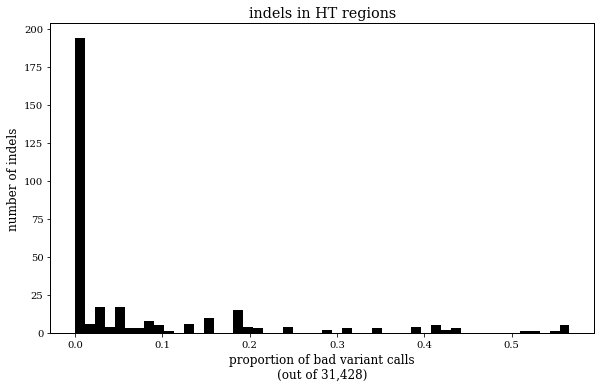

In [32]:
fig, ax = plt.subplots()

ax.set_title('indels in HT regions')
ax.hist(HT_indel_i_prop_bad_calls, color = 'black', bins = 50)
ax.set_ylabel('number of indels', color='black')
ax.set_xlabel('proportion of bad variant calls\n(out of 31,428)', color='black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
fig.tight_layout()
plt.show()

In [33]:
SSR_indel_i_prop_bad_calls = np.array([(float(np.sum(INDEL_genotypes_array[indel_i_index,:] == 9)) / 31428.0) for indel_i_index in SSR_indel_indices])

# create series
SSR_indel_i_prop_bad_calls = dict(zip(SSR_indel_indices, SSR_indel_i_prop_bad_calls))
SSR_indel_i_prop_bad_calls = pd.Series(SSR_indel_i_prop_bad_calls)

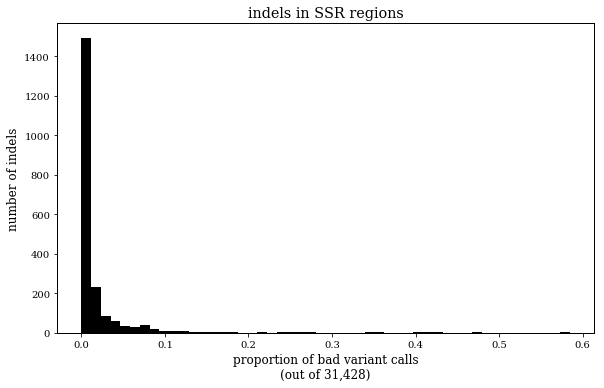

In [34]:
fig, ax = plt.subplots()

ax.set_title('indels in SSR regions')
ax.hist(SSR_indel_i_prop_bad_calls, color = 'black', bins = 50)
ax.set_ylabel('number of indels', color='black')
ax.set_xlabel('proportion of bad variant calls\n(out of 31,428)', color='black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)
fig.tight_layout()
plt.show()

#### dropped SNP sites where missing calls >= 10% of isolates

In [35]:
HT_indel_i_prop_bad_calls.shape

(330,)

In [36]:
np.sum(HT_indel_i_prop_bad_calls >= 0.1)

76

In [37]:
SSR_indel_i_prop_bad_calls.shape

(2077,)

In [38]:
np.sum(SSR_indel_i_prop_bad_calls >= 0.1)

81

#### check to see with repeat regions correspond to INDELs with high proportion of missing calls

In [39]:
HT_indel_i_prop_bad_calls_keys = [INDEL_annotation_DF.loc[indel_i, 'key'] for indel_i in HT_indel_i_prop_bad_calls[HT_indel_i_prop_bad_calls >= 0.1].index]
SSR_indel_i_prop_bad_calls_keys = [INDEL_annotation_DF.loc[indel_i, 'key'] for indel_i in SSR_indel_i_prop_bad_calls[SSR_indel_i_prop_bad_calls >= 0.1].index]

In [40]:
len(HT_indel_i_prop_bad_calls_keys)

76

In [41]:
len(SSR_indel_i_prop_bad_calls_keys)

81

In [42]:
all_homoplasic_INDELs_key_indexed = all_homoplasic_INDELs.copy()
all_homoplasic_INDELs_key_indexed = all_homoplasic_INDELs_key_indexed.set_index('key', drop = True)

In [43]:
high_prop_bad_calls_HT_homoplasic_INDELs = all_homoplasic_INDELs_key_indexed.loc[HT_indel_i_prop_bad_calls_keys,:]
high_prop_bad_calls_SSR_homoplasic_INDELs = all_homoplasic_INDELs_key_indexed.loc[SSR_indel_i_prop_bad_calls_keys,:]

In [44]:
high_prop_bad_calls_HT_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,2,3,4A,4B,4C,5,6,total,num_isolates,repeat_region
key,,,,,,,,,,,,,,,,,,,,,
C_868160_CGGG,868160,C,CGGG,Non-Essential,Rv0774c,Rv0774c,192,ins,inframe,64,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2,HT
CG_868160_C,868160,CG,C,Non-Essential,Rv0774c,Rv0774c,192,del,frameshift,64,...,10.0,3.0,1.0,6.0,9.0,0.0,0.0,32.0,77,HT
C_868160_CG,868160,C,CG,Non-Essential,Rv0774c,Rv0774c,192,ins,frameshift,64,...,10.0,4.0,3.0,4.0,5.0,0.0,0.0,31.0,73,HT
C_868160_CGG,868160,C,CGG,Non-Essential,Rv0774c,Rv0774c,192,ins,frameshift,64,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,HT
G_928285_GC,928285,G,GC,PE/PPE,PE_PGRS14,Rv0834c,2201,ins,frameshift,734,...,3.0,1.0,3.0,2.0,3.0,0.0,0.0,16.0,49,HT


In [45]:
high_prop_bad_calls_HT_homoplasic_INDELs.shape

(76, 22)

In [46]:
high_prop_bad_calls_HT_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,2,3,4A,4B,4C,5,6,total,num_isolates,repeat_region
key,,,,,,,,,,,,,,,,,,,,,
C_868160_CGGG,868160,C,CGGG,Non-Essential,Rv0774c,Rv0774c,192,ins,inframe,64,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2,HT
CG_868160_C,868160,CG,C,Non-Essential,Rv0774c,Rv0774c,192,del,frameshift,64,...,10.0,3.0,1.0,6.0,9.0,0.0,0.0,32.0,77,HT
C_868160_CG,868160,C,CG,Non-Essential,Rv0774c,Rv0774c,192,ins,frameshift,64,...,10.0,4.0,3.0,4.0,5.0,0.0,0.0,31.0,73,HT
C_868160_CGG,868160,C,CGG,Non-Essential,Rv0774c,Rv0774c,192,ins,frameshift,64,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,HT
G_928285_GC,928285,G,GC,PE/PPE,PE_PGRS14,Rv0834c,2201,ins,frameshift,734,...,3.0,1.0,3.0,2.0,3.0,0.0,0.0,16.0,49,HT


In [47]:
from collections import Counter
Counter(high_prop_bad_calls_HT_homoplasic_INDELs.gene_name)

Counter({'PE_PGRS14': 3,
         'PE_PGRS25': 3,
         'PE_PGRS31': 4,
         'PE_PGRS41': 3,
         'PE_PGRS42': 3,
         'PE_PGRS53': 1,
         'PPE13': 15,
         'PPE40': 2,
         'PPE46': 3,
         'Rv0774c': 4,
         'Rv0920c_Rv0921': 4,
         'Rv2081c': 7,
         'Rv2264c': 9,
         'apa': 2,
         'espK': 4,
         'pks2': 2,
         'wag22': 7})

In [48]:
high_prop_bad_calls_SSR_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,2,3,4A,4B,4C,5,6,total,num_isolates,repeat_region
key,,,,,,,,,,,,,,,,,,,,,
AC_80528_A,80528,AC,A,None,Rv0071_Rv0072,Rv0071_Rv0072,None,del,frameshift,None,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,SSR
T_340617_TGCG,340617,T,TGCG,PE/PPE,PPE3,Rv0280,1254,ins,inframe,418,...,17.0,3.0,0.0,0.0,2.0,0.0,0.0,22.0,81,SSR
T_340617_TGCGGCG,340617,T,TGCGGCG,PE/PPE,PPE3,Rv0280,1254,ins,inframe,418,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,8,SSR
TGCG_340617_T,340617,TGCG,T,PE/PPE,PPE3,Rv0280,1254,del,inframe,418,...,3.0,3.0,3.0,7.0,2.0,0.0,1.0,22.0,40,SSR
C_340625_CGGT,340625,C,CGGT,PE/PPE,PPE3,Rv0280,1262,ins,inframe,421,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,SSR


In [49]:
high_prop_bad_calls_SSR_homoplasic_INDELs.shape

(81, 22)

In [50]:
Counter(high_prop_bad_calls_SSR_homoplasic_INDELs.gene_name)

Counter({'PE27A_esxR': 1,
         'PE_PGRS15': 5,
         'PE_PGRS21': 1,
         'PE_PGRS23': 1,
         'PE_PGRS27': 4,
         'PE_PGRS32': 1,
         'PE_PGRS34': 1,
         'PE_PGRS36': 3,
         'PE_PGRS42': 2,
         'PE_PGRS46': 1,
         'PE_PGRS49': 1,
         'PE_PGRS50': 1,
         'PPE10': 1,
         'PPE11': 1,
         'PPE12': 1,
         'PPE3': 6,
         'PPE4': 1,
         'PPE40': 1,
         'PPE50': 2,
         'PPE54': 3,
         'PPE55': 2,
         'PPE56': 2,
         'PPE62': 2,
         'PPE8': 1,
         'Rv0071_Rv0072': 1,
         'Rv0480c_Rv0481c': 1,
         'Rv0538': 1,
         'Rv0612': 1,
         'Rv0650': 1,
         'Rv0774c': 1,
         'Rv0804': 2,
         'Rv0920c_Rv0921': 1,
         'Rv1004c': 1,
         'Rv1578c_Rv1579c': 1,
         'Rv1581c_Rv1582c': 1,
         'Rv1760': 1,
         'Rv1762c_Rv1763': 1,
         'Rv2082': 2,
         'Rv2100': 1,
         'Rv2262c': 1,
         'Rv2507': 1,
         'Rv3517': 1,
 

### filter out INDELs in HT/SSR regions that have $\ge 10\%$ missing calls in INDEL genotypes matrix

In [52]:
high_prop_bad_calls_HT_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,2,3,4A,4B,4C,5,6,total,num_isolates,repeat_region
key,,,,,,,,,,,,,,,,,,,,,
C_868160_CGGG,868160,C,CGGG,Non-Essential,Rv0774c,Rv0774c,192,ins,inframe,64,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2,HT
CG_868160_C,868160,CG,C,Non-Essential,Rv0774c,Rv0774c,192,del,frameshift,64,...,10.0,3.0,1.0,6.0,9.0,0.0,0.0,32.0,77,HT
C_868160_CG,868160,C,CG,Non-Essential,Rv0774c,Rv0774c,192,ins,frameshift,64,...,10.0,4.0,3.0,4.0,5.0,0.0,0.0,31.0,73,HT
C_868160_CGG,868160,C,CGG,Non-Essential,Rv0774c,Rv0774c,192,ins,frameshift,64,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,HT
G_928285_GC,928285,G,GC,PE/PPE,PE_PGRS14,Rv0834c,2201,ins,frameshift,734,...,3.0,1.0,3.0,2.0,3.0,0.0,0.0,16.0,49,HT


In [53]:
high_prop_bad_calls_SSR_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,2,3,4A,4B,4C,5,6,total,num_isolates,repeat_region
key,,,,,,,,,,,,,,,,,,,,,
AC_80528_A,80528,AC,A,None,Rv0071_Rv0072,Rv0071_Rv0072,None,del,frameshift,None,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,SSR
T_340617_TGCG,340617,T,TGCG,PE/PPE,PPE3,Rv0280,1254,ins,inframe,418,...,17.0,3.0,0.0,0.0,2.0,0.0,0.0,22.0,81,SSR
T_340617_TGCGGCG,340617,T,TGCGGCG,PE/PPE,PPE3,Rv0280,1254,ins,inframe,418,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,8,SSR
TGCG_340617_T,340617,TGCG,T,PE/PPE,PPE3,Rv0280,1254,del,inframe,418,...,3.0,3.0,3.0,7.0,2.0,0.0,1.0,22.0,40,SSR
C_340625_CGGT,340625,C,CGGT,PE/PPE,PPE3,Rv0280,1262,ins,inframe,421,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,SSR


all INDELs minus HT INDELs & SSR INDELs

In [60]:
all_homoplasic_INDELs.shape[0] - (high_prop_bad_calls_HT_homoplasic_INDELs.shape[0] + high_prop_bad_calls_SSR_homoplasic_INDELs.shape[0])

46149

In [61]:
HT_SSR_indels_drop_filter = np.array([(indel_i not in high_prop_bad_calls_HT_homoplasic_INDELs.index) and (indel_i not in high_prop_bad_calls_SSR_homoplasic_INDELs.index) for indel_i in all_homoplasic_INDELs.key])
all_homoplasic_INDELs = all_homoplasic_INDELs[HT_SSR_indels_drop_filter]

In [57]:
np.sum(HT_SSR_indels_drop_filter)

46149

In [62]:
all_homoplasic_INDELs.shape

(46149, 23)

####################################################################################################################################################################################

## [2] Aggregate INDELs by HT & SSR region

####################################################################################################################################################################################

### [2.1] HTs

In [24]:
homopolymeric_regions_from_Luca.head()

,Chromosome,chromStart,chromEnd,polyNT,locus_tag,gene_name
0,NC_000962.3,36470,36477,CCCCCCC,Rv0032,bioF2
1,NC_000962.3,71453,71460,CCCCCCC,Rv0064,Rv0064
2,NC_000962.3,191391,191398,CCCCCCC,Rv0161,Rv0161
3,NC_000962.3,238807,238814,CCCCCCC,Rv0202c,mmpL11
4,NC_000962.3,587728,587735,CCCCCCC,Rv0497,Rv0497


In [25]:
homopolymeric_regions_from_Luca.shape

(145, 6)

In [26]:
# subset to INDELs that occur within HT regions
HT_homoplasic_INDELs = all_homoplasic_INDELs[all_homoplasic_INDELs.repeat_region == 'HT']

# further subset to frameshift HT indels
HT_homoplasic_frameshifts = HT_homoplasic_INDELs[HT_homoplasic_INDELs.INDEL_type == 'frameshift']

In [27]:
HT_homoplasic_INDELs.shape

(330, 23)

In [28]:
HT_homoplasic_frameshifts.shape

(294, 23)

#### Tally the number of *frameshifts* that occur in each coding HT and *INDELs* that occur in each intergenic HT

In [29]:
num_INDEL_homoplasies_list = []
num_isolates_with_INDEL_list = []

#iterate through each homopolymeric region
for chromsStart_i , chromEnd_i, locus_tag_i in zip(homopolymeric_regions_from_Luca.chromStart, homopolymeric_regions_from_Luca.chromEnd, homopolymeric_regions_from_Luca.locus_tag):
    
    #define a list of H37Rv coordinates that corresponds to this homopolymeric region (- 1 bp already accounted for in HT dataframe)
    homopolymeric_region_i_coords = np.arange(chromsStart_i, chromEnd_i + 1)
    
    # HT located in CODING region
    if (('inter' not in locus_tag_i) and ('nc' not in locus_tag_i)):

        # Frameshifts
        #create a filter for Frameshifts that occur in this region
        homoplasy_INDEL_filter = np.array( [INDEL_i_pos in homopolymeric_region_i_coords for INDEL_i_pos in HT_homoplasic_frameshifts.pos] )

        #count number of homoplasy INDELs in regions and store in list
        num_INDEL_homoplasies_list.append(HT_homoplasic_frameshifts[homoplasy_INDEL_filter].total.astype(float).sum())

        #count the number of isolates that have an INDEL in region and store in list
        num_isolates_with_INDEL_list.append(HT_homoplasic_frameshifts[homoplasy_INDEL_filter].num_isolates.astype(float).sum())
        
    # HT located in Non-Coding region (ncRNA or intergenic)
    else:
        
        # INDELs
        #create a filter for INDELs that occur in this region
        homoplasy_INDEL_filter = np.array( [INDEL_i_pos in homopolymeric_region_i_coords for INDEL_i_pos in HT_homoplasic_INDELs.pos] )

        #count number of homoplasy INDELs in regions and store in list
        num_INDEL_homoplasies_list.append(HT_homoplasic_INDELs[homoplasy_INDEL_filter].total.astype(float).sum())

        #count the number of isolates that have an INDEL in region and store in list
        num_isolates_with_INDEL_list.append(HT_homoplasic_INDELs[homoplasy_INDEL_filter].num_isolates.astype(float).sum())
    
#append lists to DataFrame of homopolymeric regions
homopolymeric_regions_from_Luca.loc[: , 'INDEL_homoplasy'] = num_INDEL_homoplasies_list
homopolymeric_regions_from_Luca.loc[: , 'num_isolates_with_INDEL'] = num_isolates_with_INDEL_list
homopolymeric_regions_from_Luca.sort_values(by = 'INDEL_homoplasy' , ascending = False, inplace = True)
homopolymeric_regions_from_Luca.reset_index(inplace=True,drop=True)

#convert datatypes from float > int
convert_dict = {'INDEL_homoplasy':int, 'num_isolates_with_INDEL':int}
homopolymeric_regions_from_Luca = homopolymeric_regions_from_Luca.astype(convert_dict)

In [30]:
homopolymeric_regions_from_Luca.head(n=40)

,Chromosome,chromStart,chromEnd,polyNT,locus_tag,gene_name,INDEL_homoplasy,num_isolates_with_INDEL
0,NC_000962.3,976897,976906,GGGGGGGGG,Rv0878c,PPE13,2317,8351
1,NC_000962.3,854252,854261,CCCCCCCCC,inter_Rv0759c_Rv0760c,inter_Rv0759c_Rv0760c,776,28077
2,NC_000962.3,976889,976896,TTTTTTTT,Rv0878c,PPE13,771,5641
3,NC_000962.3,1992323,1992331,CCCCCCCC,Rv1759c,wag22,578,4052
4,NC_000962.3,2338194,2338202,CCCCCCCC,Rv2081c,Rv2081c,360,4596
5,NC_000962.3,4139183,4139190,CCCCCCC,Rv3696c,glpK,282,388
6,NC_000962.3,1333661,1333668,GGGGGGG,Rv1190,Rv1190,277,914
7,NC_000962.3,4323354,4323361,GGGGGGG,inter_Rv3848_Rv3849,inter_Rv3848_espR,269,1355
8,NC_000962.3,2234247,2234254,GGGGGGG,inter_Rv1990c_Rv1991c,inter_Rv1990c_mazF6,217,901
9,NC_000962.3,364498,364505,GGGGGGG,inter_Rv0301_Rv0302,inter_vapC2_Rv0302,216,676


Take **top 45** HT regions

In [31]:
top_homopolymeric_regions_from_Luca = homopolymeric_regions_from_Luca.head(n=45)

**Exclude** *PPE13* HT with a lower Hs count since the HTs in *PPE13* are adjacent and naturally occurring deletion in one HT and placing an insertion in the other will lead to what looks like a substitution

- if expected variant calls are -T in HT1 & +G in HT2
- if expected variant calls are +T in HT1 & -G in HT2

then naturally occuring deletion along with "placed" framshift in assembly genome will look like a SNS

In [32]:
top_homopolymeric_regions_from_Luca.drop(labels=[2], axis = 0, inplace = True)
top_homopolymeric_regions_from_Luca.reset_index(inplace = True, drop = True)

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
top_homopolymeric_regions_from_Luca.shape

(44, 8)

In [34]:
top_homopolymeric_regions_from_Luca.head()

,Chromosome,chromStart,chromEnd,polyNT,locus_tag,gene_name,INDEL_homoplasy,num_isolates_with_INDEL
0,NC_000962.3,976897,976906,GGGGGGGGG,Rv0878c,PPE13,2317,8351
1,NC_000962.3,854252,854261,CCCCCCCCC,inter_Rv0759c_Rv0760c,inter_Rv0759c_Rv0760c,776,28077
2,NC_000962.3,1992323,1992331,CCCCCCCC,Rv1759c,wag22,578,4052
3,NC_000962.3,2338194,2338202,CCCCCCCC,Rv2081c,Rv2081c,360,4596
4,NC_000962.3,4139183,4139190,CCCCCCC,Rv3696c,glpK,282,388


In [35]:
top_homopolymeric_regions_from_Luca.tail()

,Chromosome,chromStart,chromEnd,polyNT,locus_tag,gene_name,INDEL_homoplasy,num_isolates_with_INDEL
39,NC_000962.3,2001789,2001796,GGGGGGG,Rv1768,PE_PGRS31,57,361
40,NC_000962.3,3559990,3559997,CCCCCCC,Rv3192,Rv3192,55,152
41,NC_000962.3,3377346,3377353,CCCCCCC,Rv3018c,PPE46,54,116
42,NC_000962.3,2867737,2867744,CCCCCCC,Rv2544,lppB,50,262
43,NC_000962.3,4298220,4298227,GGGGGGG,Rv3825c,pks2,48,96


### [2.2] SSRs

In [36]:
SSR_H37Rv_df.head()

,H37Rv_start,H37Rv_end,motif,repeats
0,560,569,CGC,3
1,561,570,GCC,3
2,642,648,AC,3
3,1120,1126,GC,3
4,1407,1413,CA,3


In [37]:
SSR_H37Rv_df.shape

(18316, 4)

In [38]:
# subset to INDELs that occur within SSR regions
SSR_homoplasic_INDELs = all_homoplasic_INDELs[all_homoplasic_INDELs.repeat_region == 'SSR']

In [39]:
SSR_homoplasic_INDELs.shape

(2077, 23)

In [40]:
SSR_homoplasic_INDELs.sort_values(by='num_isolates',ascending=False).head(n=30)

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,2,3,4A,4B,4C,5,6,total,num_isolates,repeat_region
9336,830868,G,GGC,Non-Essential,Rv0739,Rv0739,14,ins,frameshift,5,...,50.0,3.0,1.0,0.0,1.0,1.0,1.0,62.0,12668,SSR
24929,2273733,TC,T,Non-Essential,dosT,Rv2027c,776,del,frameshift,259,...,4.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,7748,SSR
17487,1625332,C,CGGT,Essential,opcA,Rv1446c,34,ins,inframe,12,...,184.0,2.0,0.0,0.0,0.0,0.0,0.0,186.0,5157,SSR
41740,3998059,AGGC,A,PE/PPE,PPE64,Rv3558,80,del,inframe,27,...,5.0,1.0,3.0,18.0,7.0,0.0,0.0,46.0,5139,SSR
34146,3159998,CAA,C,Non-Essential,Rv2850c,Rv2850c,57,del,frameshift,19,...,0.0,0.0,18.0,0.0,0.0,0.0,0.0,18.0,4323,SSR
18119,1696499,G,GCGGT,None,Rv1506c_Rv1507c,Rv1506c_Rv1507c,None,ins,frameshift,None,...,1.0,1.0,0.0,0.0,1.0,3.0,1.0,8.0,2796,SSR
12829,1151485,CGT,C,Antigen,kdpD,Rv1028c,202,del,frameshift,68,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,2754,SSR
10495,936620,CCCA,C,Non-Essential,pip,Rv0840c,698,del,inframe,233,...,0.0,3.0,0.0,0.0,1.0,0.0,0.0,5.0,2607,SSR
752,55540,G,GCCGCCGCCT,Non-Essential,ponA1,Rv0050,1878,ins,inframe,626,...,272.0,0.0,0.0,0.0,0.0,6.0,5.0,397.0,2238,SSR
6427,552495,G,GCTA,Non-Essential,Rv0461,Rv0461,470,ins,inframe,157,...,0.0,0.0,97.0,0.0,0.0,0.0,0.0,97.0,1641,SSR


#### Tally the number of *INDELs* that occur in each SSR

In [41]:
num_INDEL_homoplasies_list = []
num_isolates_with_INDEL_list = []

#iterate through each homopolymeric region
for chromsStart_i , chromEnd_i in zip(SSR_H37Rv_df.H37Rv_start, SSR_H37Rv_df.H37Rv_end):
    
    #define a list of H37Rv coordinates that corresponds to this homopolymeric region (- 1 bp already accounted for in HT dataframe)
    homopolymeric_region_i_coords = np.arange(chromsStart_i, chromEnd_i + 1)
        
    # INDELs
    #create a filter for INDELs that occur in this region
    homoplasy_INDEL_filter = np.array( [INDEL_i_pos in homopolymeric_region_i_coords for INDEL_i_pos in SSR_homoplasic_INDELs.pos] )

    #count number of homoplasy INDELs in regions and store in list
    num_INDEL_homoplasies_list.append(SSR_homoplasic_INDELs[homoplasy_INDEL_filter].total.astype(float).sum())

    #count the number of isolates that have an INDEL in region and store in list
    num_isolates_with_INDEL_list.append(SSR_homoplasic_INDELs[homoplasy_INDEL_filter].num_isolates.astype(float).sum())
    
#append lists to DataFrame of homopolymeric regions
SSR_H37Rv_df.loc[: , 'INDEL_homoplasy'] = num_INDEL_homoplasies_list
SSR_H37Rv_df.loc[: , 'num_isolates_with_INDEL'] = num_isolates_with_INDEL_list
SSR_H37Rv_df.sort_values(by = 'INDEL_homoplasy' , ascending = False, inplace = True)
SSR_H37Rv_df.reset_index(inplace=True,drop=True)

#convert datatypes from float > int
convert_dict = {'INDEL_homoplasy':int, 'num_isolates_with_INDEL':int}
SSR_H37Rv_df = SSR_H37Rv_df.astype(convert_dict)

In [42]:
SSR_H37Rv_df.shape

(18316, 6)

Take **top 10** SSR regions that are unique in H37Rv

In [43]:
SSR_H37Rv_df.head(n=20)

,H37Rv_start,H37Rv_end,motif,repeats,INDEL_homoplasy,num_isolates_with_INDEL
0,55533,55554,GCC,7,699,4056
1,55533,55551,GCCGCC,3,699,4056
2,55535,55553,CGCCGC,3,591,3621
3,55534,55555,CCG,7,591,3621
4,55534,55552,CCGCCG,3,591,3621
5,55535,55553,CGC,6,591,3621
6,3247858,3247866,GC,4,325,471
7,3247859,3247865,CG,3,325,471
8,1625332,1625344,GGT,4,207,5187
9,2873093,2873108,CCA,5,178,1154


In [44]:
top_20_unique_SSRs = []
for SSR_i in SSR_H37Rv_df.index:
    if np.shape(SSR_H37Rv_df[(SSR_H37Rv_df.motif == SSR_H37Rv_df.loc[SSR_i, :].motif) & (SSR_H37Rv_df.repeats == SSR_H37Rv_df.loc[SSR_i, :].repeats)])[0] == 1:
        top_20_unique_SSRs.append(SSR_i)
    if len(top_20_unique_SSRs) == 20:
        break

In [45]:
SSR_H37Rv_df.loc[top_20_unique_SSRs , :]

,H37Rv_start,H37Rv_end,motif,repeats,INDEL_homoplasy,num_isolates_with_INDEL
0,55533,55554,GCC,7,699,4056
2,55535,55553,CGCCGC,3,591,3621
3,55534,55555,CCG,7,591,3621
5,55535,55553,CGC,6,591,3621
18,552495,552504,CTA,3,102,1657
26,340617,340632,GCG,5,51,132
30,2042049,2042067,CGGGGC,3,43,171
32,1112922,1112946,CGAATA,4,38,83
43,1339817,1339841,CGGCGA,4,28,48
45,2608579,2608591,TGT,4,26,601


visually inspect and find the top 10 SSRs (only include one SSR for overlapping SSRs), the **ponA1** SSR has too many allelic states (+CCGCCGCCT, +CCGCCT, -GCC) so we'll remove this SSR from simulations because it's too unstable to reliably map

In [71]:
top_unique_SSR_regions = SSR_H37Rv_df.loc[[18,26,30,32,43,45,54,81,98,113],:]
# rename some cols
top_unique_SSR_regions.rename(columns = {'H37Rv_start':'chromStart','H37Rv_end':'chromEnd','motif':'polyNT'}, inplace = True)

An example of an SSR that is not unique, and how some SSR sequences repeat near eachother on the genome

In [72]:
SSR_i = 13
np.shape(SSR_H37Rv_df[(SSR_H37Rv_df.motif == SSR_H37Rv_df.loc[SSR_i, :].motif) & (SSR_H37Rv_df.repeats == SSR_H37Rv_df.loc[SSR_i, :].repeats)])[0]

10

In [73]:
SSR_H37Rv_df[(SSR_H37Rv_df.motif == SSR_H37Rv_df.loc[SSR_i, :].motif) & (SSR_H37Rv_df.repeats == SSR_H37Rv_df.loc[SSR_i, :].repeats)]

,H37Rv_start,H37Rv_end,motif,repeats,INDEL_homoplasy,num_isolates_with_INDEL
13,3969423,3969438,GCC,5,156,1305
24,3972244,3972259,GCC,5,56,135
111,2639443,2639458,GCC,5,10,24
5795,2639032,2639047,GCC,5,0,0
10720,672721,672736,GCC,5,0,0
11867,968966,968981,GCC,5,0,0
15450,2357163,2357178,GCC,5,0,0
16919,1191359,1191374,GCC,5,0,0
16941,1189431,1189446,GCC,5,0,0
16943,1189185,1189200,GCC,5,0,0


Chunk below ends up not being used

Now we have to make sure that for each SSR region, we take the **largest** SSR sequence if the SSR sequence in dataframe above is a sub-sequence of the larger SSR sequence

In [60]:
H37Rv_start = 55533
H37Rv_end = 55551
SSR_i_regions_df = SSR_H37Rv_df[(SSR_H37Rv_df.H37Rv_start >= H37Rv_start-15) & (SSR_H37Rv_df.H37Rv_end <= H37Rv_end+15)] # subset to SSR regions around this SSR
SSR_i_regions_df.loc[:,'SSR_len'] = [len(repeat_unit)*num_repeats for repeat_unit,num_repeats in zip(SSR_i_regions_df.motif, SSR_i_regions_df.repeats)] # add length of sequence as column
SSR_i_regions_df.sort_values(by='SSR_len', ascending = False, inplace = True)

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [61]:
SSR_i_regions_df

,H37Rv_start,H37Rv_end,motif,repeats,INDEL_homoplasy,num_isolates_with_INDEL,SSR_len
0,55533,55554,GCC,7,699,4056,21
3,55534,55555,CCG,7,591,3621,21
1,55533,55551,GCCGCC,3,699,4056,18
2,55535,55553,CGCCGC,3,591,3621,18
4,55534,55552,CCGCCG,3,591,3621,18
5,55535,55553,CGC,6,591,3621,18
10,55542,55551,GCC,3,171,1351,9
11,55543,55552,CCG,3,170,1350,9
172,55544,55553,CGC,3,6,12,9


In [62]:
H37Rv_start = 3247858
H37Rv_end = 3247866
SSR_i_regions_df = SSR_H37Rv_df[(SSR_H37Rv_df.H37Rv_start >= H37Rv_start-15) & (SSR_H37Rv_df.H37Rv_end <= H37Rv_end+15)] # subset to SSR regions around this SSR
SSR_i_regions_df.loc[:,'SSR_len'] = [len(repeat_unit)*num_repeats for repeat_unit,num_repeats in zip(SSR_i_regions_df.motif, SSR_i_regions_df.repeats)] # add length of sequence as column
SSR_i_regions_df.sort_values(by='SSR_len', ascending = False, inplace = True)

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [63]:
SSR_i_regions_df

,H37Rv_start,H37Rv_end,motif,repeats,INDEL_homoplasy,num_isolates_with_INDEL,SSR_len
6,3247858,3247866,GC,4,325,471,8
7,3247859,3247865,CG,3,325,471,6


In [64]:
H37Rv_start = 3528971
H37Rv_end = 3528986
SSR_i_regions_df = SSR_H37Rv_df[(SSR_H37Rv_df.H37Rv_start >= H37Rv_start-15) & (SSR_H37Rv_df.H37Rv_end <= H37Rv_end+15)] # subset to SSR regions around this SSR
SSR_i_regions_df.loc[:,'SSR_len'] = [len(repeat_unit)*num_repeats for repeat_unit,num_repeats in zip(SSR_i_regions_df.motif, SSR_i_regions_df.repeats)] # add length of sequence as column
SSR_i_regions_df.sort_values(by='SSR_len', ascending = False, inplace = True)

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [65]:
SSR_i_regions_df

,H37Rv_start,H37Rv_end,motif,repeats,INDEL_homoplasy,num_isolates_with_INDEL,SSR_len
16,3528971,3528986,CGC,5,130,437,15
8794,3528972,3528984,GCC,4,0,0,12
8796,3528973,3528985,CCG,4,0,0,12


### [2.3] concatenate top HTs & top SSRs

In [72]:
# modify SSR dataframe
top_unique_SSR_regions.loc[:,'Chromosome'] = ['NC_000962.3']*np.shape(top_unique_SSR_regions)[0]
top_unique_SSR_regions.loc[:,'type'] = ['SSR']*np.shape(top_unique_SSR_regions)[0]

# modify HT dataframe
top_homopolymeric_regions_from_Luca.loc[:,'repeats'] = [1]*np.shape(top_homopolymeric_regions_from_Luca)[0]
top_homopolymeric_regions_from_Luca.loc[:,'type'] = ['HT']*np.shape(top_homopolymeric_regions_from_Luca)[0]

In [73]:
top_unique_SSR_regions

,chromStart,chromEnd,polyNT,repeats,INDEL_homoplasy,num_isolates_with_INDEL,Chromosome,type
18,552495,552504,CTA,3,102,1657,NC_000962.3,SSR
26,340617,340632,GCG,5,51,132,NC_000962.3,SSR
30,2042049,2042067,CGGGGC,3,43,171,NC_000962.3,SSR
32,1112922,1112946,CGAATA,4,38,83,NC_000962.3,SSR
43,1339817,1339841,CGGCGA,4,28,48,NC_000962.3,SSR
45,2608579,2608591,TGT,4,26,601,NC_000962.3,SSR
54,4378048,4378060,TCT,4,21,420,NC_000962.3,SSR
81,613371,613386,TGA,5,15,28,NC_000962.3,SSR
98,1696591,1696601,TG,5,11,15,NC_000962.3,SSR
113,2328760,2328778,CGTCGG,3,10,21,NC_000962.3,SSR


In [74]:
top_homopolymeric_regions_from_Luca

,Chromosome,chromStart,chromEnd,polyNT,locus_tag,gene_name,INDEL_homoplasy,num_isolates_with_INDEL,repeats,type
0,NC_000962.3,976897,976906,GGGGGGGGG,Rv0878c,PPE13,2317,8351,1,HT
1,NC_000962.3,854252,854261,CCCCCCCCC,inter_Rv0759c_Rv0760c,inter_Rv0759c_Rv0760c,776,28077,1,HT
2,NC_000962.3,1992323,1992331,CCCCCCCC,Rv1759c,wag22,578,4052,1,HT
3,NC_000962.3,2338194,2338202,CCCCCCCC,Rv2081c,Rv2081c,360,4596,1,HT
4,NC_000962.3,4139183,4139190,CCCCCCC,Rv3696c,glpK,282,388,1,HT
5,NC_000962.3,1333661,1333668,GGGGGGG,Rv1190,Rv1190,277,914,1,HT
6,NC_000962.3,4323354,4323361,GGGGGGG,inter_Rv3848_Rv3849,inter_Rv3848_espR,269,1355,1,HT
7,NC_000962.3,2234247,2234254,GGGGGGG,inter_Rv1990c_Rv1991c,inter_Rv1990c_mazF6,217,901,1,HT
8,NC_000962.3,364498,364505,GGGGGGG,inter_Rv0301_Rv0302,inter_vapC2_Rv0302,216,676,1,HT
9,NC_000962.3,3742991,3742998,GGGGGGG,inter_Rv3345c_Rv3346c,inter_PE_PGRS50_Rv3346c,214,2229,1,HT


In [75]:
repeat_regions_to_map = top_homopolymeric_regions_from_Luca.append(top_unique_SSR_regions)
repeat_regions_to_map.reset_index(inplace = True, drop = True)

In [76]:
repeat_regions_to_map

,Chromosome,INDEL_homoplasy,chromEnd,chromStart,gene_name,locus_tag,num_isolates_with_INDEL,polyNT,repeats,type
0,NC_000962.3,2317,976906,976897,PPE13,Rv0878c,8351,GGGGGGGGG,1,HT
1,NC_000962.3,776,854261,854252,inter_Rv0759c_Rv0760c,inter_Rv0759c_Rv0760c,28077,CCCCCCCCC,1,HT
2,NC_000962.3,578,1992331,1992323,wag22,Rv1759c,4052,CCCCCCCC,1,HT
3,NC_000962.3,360,2338202,2338194,Rv2081c,Rv2081c,4596,CCCCCCCC,1,HT
4,NC_000962.3,282,4139190,4139183,glpK,Rv3696c,388,CCCCCCC,1,HT
5,NC_000962.3,277,1333668,1333661,Rv1190,Rv1190,914,GGGGGGG,1,HT
6,NC_000962.3,269,4323361,4323354,inter_Rv3848_espR,inter_Rv3848_Rv3849,1355,GGGGGGG,1,HT
7,NC_000962.3,217,2234254,2234247,inter_Rv1990c_mazF6,inter_Rv1990c_Rv1991c,901,GGGGGGG,1,HT
8,NC_000962.3,216,364505,364498,inter_vapC2_Rv0302,inter_Rv0301_Rv0302,676,GGGGGGG,1,HT
9,NC_000962.3,214,3742998,3742991,inter_PE_PGRS50_Rv3346c,inter_Rv3345c_Rv3346c,2229,GGGGGGG,1,HT


save regions to map for downstream analysis

In [77]:
repeat_regions_to_map.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/HT_SSR_recall_sims/HT_SSR_H37Rv_regions_to_map.pkl')

#### Aside: let's check how many times each RU (repeat unit) appears in H37Rv for the SSRs that are included in simulations

Load SSR repeat regions

In [3]:
repeat_regions_to_map = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/HT_SSR_recall_sims/HT_SSR_H37Rv_regions_to_map.pkl')
SSR_repeat_regions_to_map = repeat_regions_to_map[repeat_regions_to_map.type == 'SSR']

In [7]:
SSR_repeat_regions_to_map

,Chromosome,INDEL_homoplasy,chromEnd,chromStart,gene_name,locus_tag,num_isolates_with_INDEL,polyNT,repeats,type
44,NC_000962.3,102,552504,552495,NaN,NaN,1657,CTA,3,SSR
45,NC_000962.3,51,340632,340617,NaN,NaN,132,GCG,5,SSR
46,NC_000962.3,43,2042067,2042049,NaN,NaN,171,CGGGGC,3,SSR
47,NC_000962.3,38,1112946,1112922,NaN,NaN,83,CGAATA,4,SSR
48,NC_000962.3,28,1339841,1339817,NaN,NaN,48,CGGCGA,4,SSR
49,NC_000962.3,26,2608591,2608579,NaN,NaN,601,TGT,4,SSR
50,NC_000962.3,21,4378060,4378048,NaN,NaN,420,TCT,4,SSR
51,NC_000962.3,15,613386,613371,NaN,NaN,28,TGA,5,SSR
52,NC_000962.3,11,1696601,1696591,NaN,NaN,15,TG,5,SSR
53,NC_000962.3,10,2328778,2328760,NaN,NaN,21,CGTCGG,3,SSR


Load H37Rv genome

In [12]:
#load reference genome and reference annotation
H37Rv = '/n/data1/hms/dbmi/farhat/bin/work-horse/bin/h37rv.fasta'
for H37Rv in SeqIO.parse(H37Rv, "fasta"):
    H37Rv.seq.alphabet = IUPAC.unambiguous_dna

In [14]:
len(H37Rv.seq)

4411532

In [20]:
RU_H37Rv_matches = []
for SSR_i_RU in SSR_repeat_regions_to_map.polyNT:
    RU_H37Rv_matches.append(H37Rv.seq.count(SSR_i_RU))

In [21]:
SSR_repeat_regions_to_map.loc[:,'RU_H37Rv_matches'] = RU_H37Rv_matches

/home/rv76/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/rv76/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
SSR_repeat_regions_to_map

,Chromosome,INDEL_homoplasy,chromEnd,chromStart,gene_name,locus_tag,num_isolates_with_INDEL,polyNT,repeats,type,RU_H37Rv_matches
44,NC_000962.3,102,552504,552495,NaN,NaN,1657,CTA,3,SSR,20557
45,NC_000962.3,51,340632,340617,NaN,NaN,132,GCG,5,SSR,155491
46,NC_000962.3,43,2042067,2042049,NaN,NaN,171,CGGGGC,3,SSR,2890
47,NC_000962.3,38,1112946,1112922,NaN,NaN,83,CGAATA,4,SSR,586
48,NC_000962.3,28,1339841,1339817,NaN,NaN,48,CGGCGA,4,SSR,7493
49,NC_000962.3,26,2608591,2608579,NaN,NaN,601,TGT,4,SSR,42487
50,NC_000962.3,21,4378060,4378048,NaN,NaN,420,TCT,4,SSR,31014
51,NC_000962.3,15,613386,613371,NaN,NaN,28,TGA,5,SSR,53139
52,NC_000962.3,11,1696601,1696591,NaN,NaN,15,TG,5,SSR,277350
53,NC_000962.3,10,2328778,2328760,NaN,NaN,21,CGTCGG,3,SSR,5440


####################################################################################################################################################################################

# [4] Load Complete Genomes & map HT regions from H37Rv to assemblies

####################################################################################################################################################################################

### [4.1] check metadata for assemblies

In [11]:
genome_assemblies = ['RW-TB008','N1274','N1272','N1202','N1177','N1176','N0155','N0153','N0145','N0091','N0072','N0054',
                     'N0004','M0017522_5','M0016737_0','M0016395_7','M0014888_3','M0011368_9','M0010874_7','M0003941_3',
                     'DNA188','DNA120','DNA091','DNA086','DNA075','DNA044','DNA028','DNA020','DNA019_Rose','AZE_02_042',
                     '02_R1896','02_R1708','02_R1179','02_R0894','01_R1430','01_R1134']

In [12]:
len(genome_assemblies)

36

In [13]:
assembly_metadata = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/HT_SSR_recall_sims/220829.36CI.ForRoger.Asms/220720.WGA158CI.PB.ONT.AsmSummary.V2.tsv', sep = '\t').set_index('SampleID')
assembly_metadata = assembly_metadata.loc[genome_assemblies, :]
assembly_metadata.reset_index(inplace = True, drop = False)

In [14]:
assembly_metadata.head()

,SampleID,numContigs_Complete,Flye_CircContig_Cov,PrimaryLineage,Lineage,Dataset_Tag,AsmApproach
0,RW-TB008,1,160,lineage8,lineage8,Ngabonziza_Lin8_2020,PBrs2_LR_Flye_I3_SR_Pilon
1,N1274,1,366,lineage3,lineage3,ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon
2,N1272,1,370,lineage5,lineage5,ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon
3,N1202,1,362,lineage6,"lineage6,lineageBOV_AFRI",ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon
4,N1177,1,338,lineage6,"lineage6,lineageBOV_AFRI",ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon


breakdown of global lineages

In [15]:
from collections import Counter

Counter(assembly_metadata.PrimaryLineage)

Counter({'lineage1': 2,
         'lineage2': 6,
         'lineage3': 3,
         'lineage4': 19,
         'lineage5': 2,
         'lineage6': 3,
         'lineage8': 1})

### [4.2] Load H37Rv reference genome and reference annotation

In [16]:
#load reference genome and reference annotation
H37Rv = '/n/data1/hms/dbmi/farhat/bin/work-horse/bin/h37rv.fasta'
for H37Rv in SeqIO.parse(H37Rv, "fasta"):
    H37Rv.seq.alphabet = IUPAC.unambiguous_dna

H37Rv_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

In [21]:
H37Rv_repeat_seq_and_flanks = 'ACTTTTTTTTTTGG'
Mtb_genome_str = H37Rv.seq
x = [i for i in range(len(Mtb_genome_str)) if Mtb_genome_str.startswith(str(H37Rv_repeat_seq_and_flanks), i)]

### [4.3] Map the $\ge7$bp HT & SSR regions from the H37Rv  query genome to target genome (flank seq = 3bp on each side of repeat region)

In [84]:
# iterate through each complete genome
for Mtb_genome_tag in genome_assemblies:
    
    print(Mtb_genome_tag)

    # load in a complete genome that will be used in simulations
    Mtb_genome = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/HT_SSR_recall_sims/220829.36CI.ForRoger.Asms/'+Mtb_genome_tag+'.fna'
    for Mtb_genome in SeqIO.parse(Mtb_genome, "fasta"):
        Mtb_genome.seq.alphabet = IUPAC.unambiguous_dna

    # convert sequence to a string
    Mtb_genome_str = str(Mtb_genome.seq)

    # Load in repeat regions that need to be mapped
    repeat_regions_to_map = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/HT_SSR_recall_sims/HT_SSR_H37Rv_regions_to_map.pkl')

    # size of seq flanking both sides of repeat region on H37Rv
    flank_size = 3

    # keep track of coordinates for best matching HT in target genome
    Mtb_genome_HT_SSR_start_coord_list = []
    Mtb_genome_HT_SSR_seq_list = []
    Mtb_genome_HT_SSR_end_coord_list = []

    # iterate through each HT/SSR in H37Rv
    iterate_i = 3
    for H37Rv_HT_SSR_start, H37Rv_HT_SSR_seq, H37Rv_HT_SSR_type, H37Rv_HT_SSR_repeats in zip(repeat_regions_to_map.chromStart, repeat_regions_to_map.polyNT, repeat_regions_to_map.type, repeat_regions_to_map.repeats):

        subseq_found = False

        # iterate and test HT sub-sequences with, +1bp, same sequence, and -1bp
        if H37Rv_HT_SSR_type == 'HT':

            H37Rv_HT_SSR_end = H37Rv_HT_SSR_start + len(H37Rv_HT_SSR_seq) # get end coord of repeat region

            left_seq_flank = H37Rv.seq[H37Rv_HT_SSR_start-flank_size:H37Rv_HT_SSR_start] # get subseq left of repeat region
            right_seq_flank = H37Rv.seq[H37Rv_HT_SSR_end:H37Rv_HT_SSR_end+flank_size] # get subseq right of repeat region

            single_bp = H37Rv_HT_SSR_seq[0]
            H37Rv_seqs_to_test = [H37Rv_HT_SSR_seq, H37Rv_HT_SSR_seq+single_bp, H37Rv_HT_SSR_seq[:-1]]

        # iterate and test SSR sub-sequences with +repeat, same sequence, and -repeat
        elif H37Rv_HT_SSR_type == 'SSR':

            H37Rv_HT_SSR_end = H37Rv_HT_SSR_start + len(H37Rv_HT_SSR_seq*H37Rv_HT_SSR_repeats) # get end coord of repeat region

            left_seq_flank = H37Rv.seq[H37Rv_HT_SSR_start-flank_size:H37Rv_HT_SSR_start] # get subseq left of repeat region
            right_seq_flank = H37Rv.seq[H37Rv_HT_SSR_end:H37Rv_HT_SSR_end+flank_size] # get subseq right of repeat region

            H37Rv_seqs_to_test = [H37Rv_HT_SSR_seq*H37Rv_HT_SSR_repeats, H37Rv_HT_SSR_seq*(H37Rv_HT_SSR_repeats+1), H37Rv_HT_SSR_seq*(H37Rv_HT_SSR_repeats-1)]

        # check sub-sequences (+ left/right flank sequences) in assembly
        for H37Rv_like_sub_seq in H37Rv_seqs_to_test:

            # concat subseqs together to get full sub-sequence to find in assembly
            H37Rv_repeat_seq_and_flanks = str(left_seq_flank) + H37Rv_like_sub_seq + str(right_seq_flank)

            HT_SSR_match_start_coords = [i for i in range(len(Mtb_genome_str)) if Mtb_genome_str.startswith(str(H37Rv_repeat_seq_and_flanks), i)]

            # check to see if sub-seq found, if found break
            if len(HT_SSR_match_start_coords) == 1:

                # start coord for full sub-sequence match in assembly genome
                HT_SSR_flanks_match_start_coord = HT_SSR_match_start_coords[0]

                # start coord for the repeat region
                HT_SSR_match_start_coord = HT_SSR_flanks_match_start_coord + flank_size
                
                # check that mapping has assembly Start coord <33kbp away from H37Rv Start coord
                if abs(HT_SSR_match_start_coord - H37Rv_HT_SSR_start) <= 33000:
                
                    subseq_found = True
                    break

            # multiple regions in H37Rv found to match sub-sequence
            elif len(HT_SSR_match_start_coords) > 1:

                # start coord for full sub-sequence match in assembly genome
                HT_SSR_flanks_match_start_coord = HT_SSR_match_start_coords

                # start coord for the repeat region
                HT_SSR_match_start_coord = [x + flank_size for x in HT_SSR_flanks_match_start_coord]
                
                # create a series of differences in chromStart coords between H37Rv and assembly
                chromStart_diff_series = pd.Series(list(abs(np.array(HT_SSR_match_start_coord) - H37Rv_HT_SSR_start)), index = HT_SSR_match_start_coord)
                
                # sort by matches that are closest coordinate wise
                chromStart_diff_series.sort_values(inplace = True, ascending = True)
                
                # take the start coordinate for the match that is closest coordinate-wise between H37Rv & assembly
                HT_SSR_match_start_coord = int(chromStart_diff_series.index[0])
                
                # check that closest mapping has assembly Start coord <33kbp away from H37Rv Start coord
                if chromStart_diff_series[HT_SSR_match_start_coord] <= 33000:
                
                    subseq_found = True
                    break

            # sub-sequence not found, keep looking...   
            else:
                pass

        # sub sequence found!
        if subseq_found == True:

            # store coordinates & seq in lists
            Mtb_genome_HT_SSR_start_coord_list.append(HT_SSR_match_start_coord)
            Mtb_genome_HT_SSR_seq_list.append(H37Rv_like_sub_seq)
            Mtb_genome_HT_SSR_end_coord_list.append(HT_SSR_match_start_coord+len(H37Rv_like_sub_seq))

        # sub sequence not found :(
        elif subseq_found == False:

            # store coordinates & seq in lists
            Mtb_genome_HT_SSR_start_coord_list.append(np.nan)
            Mtb_genome_HT_SSR_seq_list.append('no match')
            Mtb_genome_HT_SSR_end_coord_list.append(np.nan)

        # keep track of progress
        if iterate_i % 10 == 0:

            print(iterate_i)
        iterate_i += 1

    # Append mapped positions to HT regions on H37Rv
    repeat_regions_to_map.loc[:,'assembly_chromStart'] = Mtb_genome_HT_SSR_start_coord_list
    repeat_regions_to_map.loc[:,'assembly_polyNT'] = Mtb_genome_HT_SSR_seq_list
    repeat_regions_to_map.loc[:,'assembly_chromEnd'] = Mtb_genome_HT_SSR_end_coord_list
    repeat_regions_to_map.reset_index(inplace = True, drop = True)

    # save as a pickled dataframe
    repeat_regions_to_map.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/HT_SSR_recall_sims/H37Rv_to_assembly_mappings_1/HT_SSR_'+Mtb_genome_tag+'_mappings.pkl')

    # check to see how many regions didn't map for this genome
    print('Number of unmapped regions = ' + str(np.sum([seq == 'no match' for seq in repeat_regions_to_map.assembly_polyNT])))
    print('')
    print('')

RW-TB008
10
20
30
40
50
Number of unmapped regions = 3


N1274
10
20
30
40
50
Number of unmapped regions = 3


N1272
10
20
30
40
50
Number of unmapped regions = 4


N1202
10
20
30
40
50
Number of unmapped regions = 2


N1177
10
20
30
40
50
Number of unmapped regions = 3


N1176
10
20
30
40
50
Number of unmapped regions = 4


N0155
10
20
30
40
50
Number of unmapped regions = 5


N0153
10
20
30
40
50
Number of unmapped regions = 4


N0145
10
20
30
40
50
Number of unmapped regions = 4


N0091
10
20
30
40
50
Number of unmapped regions = 4


N0072
10
20
30
40
50
Number of unmapped regions = 5


N0054
10
20
30
40
50
Number of unmapped regions = 3


N0004
10
20
30
40
50
Number of unmapped regions = 3


M0017522_5
10
20
30
40
50
Number of unmapped regions = 2


M0016737_0
10
20
30
40
50
Number of unmapped regions = 0


M0016395_7
10
20
30
40
50
Number of unmapped regions = 1


M0014888_3
10
20
30
40
50
Number of unmapped regions = 0


M0011368_9
10
20
30
40
50
Number of unmapped regions = 1




### [4.4] check to see how many mappings are missing from each assembly

In [17]:
regions_mapped_dict = {}
# iterate through each complete genome
for Mtb_genome_tag in genome_assemblies:
    
    regions_mapped_df = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/HT_SSR_recall_sims/H37Rv_to_assembly_mappings_1/HT_SSR_'+Mtb_genome_tag+'_mappings.pkl')
    regions_mapped_dict[Mtb_genome_tag] = regions_mapped_df
    
# create dataframe that holds assembly ID, global lineage call, and number of regions mapped
num_regions_mapped_list = []
for Mtb_genome_tag in assembly_metadata.SampleID:
    num_regions_mapped_list.append(np.sum(regions_mapped_dict[Mtb_genome_tag].assembly_polyNT != 'no match'))
    
assembly_metadata.loc[:,'regions_mapped'] = num_regions_mapped_list

In [18]:
assembly_metadata.sort_values(by='regions_mapped')

,SampleID,numContigs_Complete,Flye_CircContig_Cov,PrimaryLineage,Lineage,Dataset_Tag,AsmApproach,regions_mapped
35,01_R1134,1,138,lineage4,lineage4,Farhat_Peru_2019,PBrs2_LR_Flye_I3_SR_Pilon,0
26,DNA028,1,437,lineage2,"lineage2,lineage2.2,lineage2.2.1",TB_Portals_24CI_R1,PBrs2_LR_Flye_I3_SR_Pilon,17
20,DNA188,1,677,lineage4,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",TB_Portals_24CI_R1,PBrs2_LR_Flye_I3_SR_Pilon,40
24,DNA075,1,753,lineage2,"lineage2,lineage2.2,lineage2.2.1",TB_Portals_24CI_R1,PBrs2_LR_Flye_I3_SR_Pilon,48
6,N0155,1,335,lineage2,"lineage2,lineage2.2,lineage2.2.1",ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon,49
10,N0072,1,358,lineage1,"lineage1,lineage1.1,lineage1.1.2",ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon,49
19,M0003941_3,1,206,lineage2,"lineage2,lineage2.2,lineage2.2.1",Farhat_Peru_2019,PBrs2_LR_Flye_I3_SR_Pilon,49
2,N1272,1,370,lineage5,lineage5,ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon,50
22,DNA091,1,807,lineage2,"lineage2,lineage2.2,lineage2.2.1",TB_Portals_24CI_R1,PBrs2_LR_Flye_I3_SR_Pilon,50
5,N1176,1,205,lineage5,lineage5,ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon,50


In [21]:
assembly_metadata.regions_mapped.median()

51.5

### [4.5] Drop assemblies with missing mappings for $> 7$ regions

In [106]:
assembly_metadata.shape

(36, 8)

In [107]:
assembly_metadata = assembly_metadata[assembly_metadata.regions_mapped >= 48]

In [108]:
assembly_metadata.shape

(33, 8)

In [109]:
genome_assemblies = list(assembly_metadata.SampleID)

In [110]:
len(genome_assemblies)

33

In [111]:
print(genome_assemblies)

['RW-TB008', 'N1274', 'N1272', 'N1202', 'N1177', 'N1176', 'N0155', 'N0153', 'N0145', 'N0091', 'N0072', 'N0054', 'N0004', 'M0017522_5', 'M0016737_0', 'M0016395_7', 'M0014888_3', 'M0011368_9', 'M0010874_7', 'M0003941_3', 'DNA120', 'DNA091', 'DNA086', 'DNA075', 'DNA044', 'DNA020', 'DNA019_Rose', 'AZE_02_042', '02_R1896', '02_R1708', '02_R1179', '02_R0894', '01_R1430']


####################################################################################################################################################################################

# [5] Analyze mappings between H37Rv and assembly HT/SSR regions

####################################################################################################################################################################################

In [4]:
genome_assemblies = ['RW-TB008', 'N1274', 'N1272', 'N1202', 'N1177', 'N1176', 'N0155', 
                     'N0153', 'N0145', 'N0091', 'N0072', 'N0054', 'N0004', 'M0017522_5', 
                     'M0016737_0', 'M0016395_7', 'M0014888_3', 'M0011368_9', 'M0010874_7', 
                     'M0003941_3', 'DNA120', 'DNA091', 'DNA086', 'DNA075', 'DNA044', 'DNA020', 
                     'DNA019_Rose', 'AZE_02_042', '02_R1896', '02_R1708', '02_R1179', '02_R0894', '01_R1430']

In [5]:
genome_assembly_mappings_dict = {}
for assembly_i in genome_assemblies:
    genome_assembly_mappings_dict[assembly_i] = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/HT_SSR_recall_sims/H37Rv_to_assembly_mappings_1/HT_SSR_'+assembly_i+'_mappings.pkl')

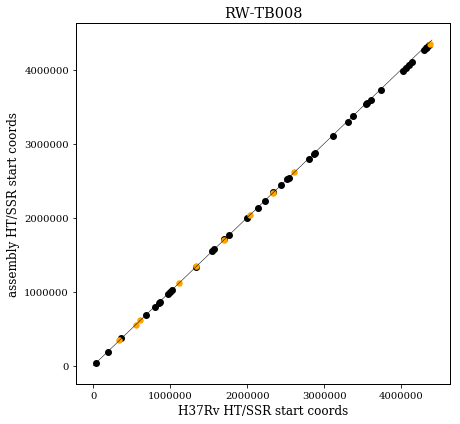

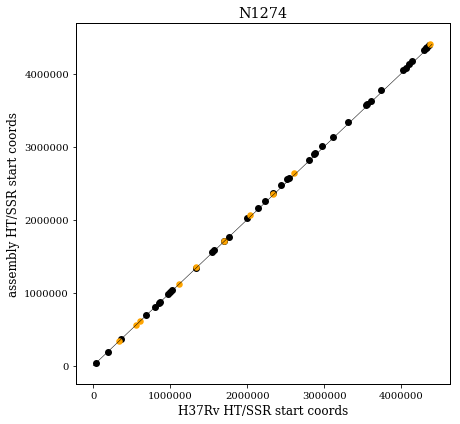

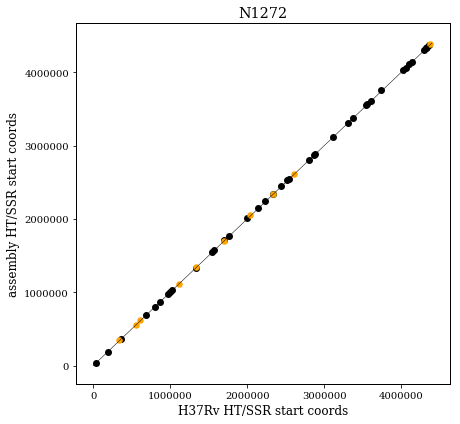

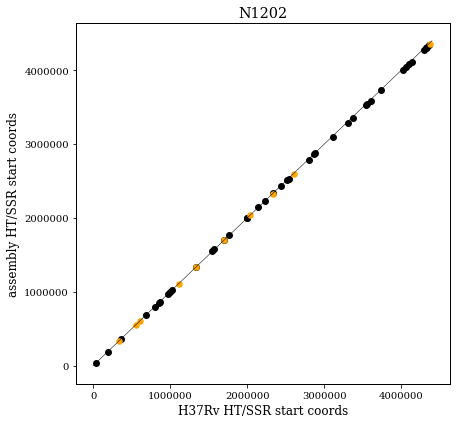

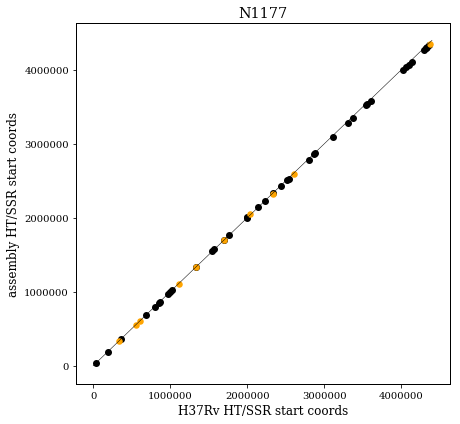

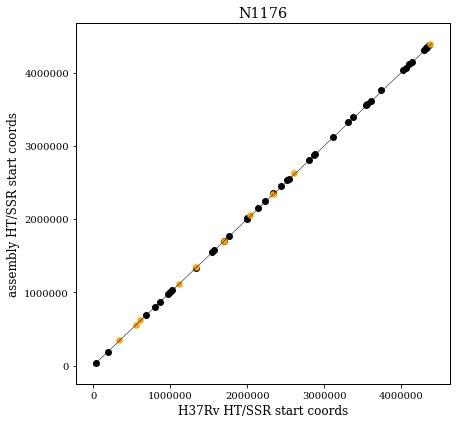

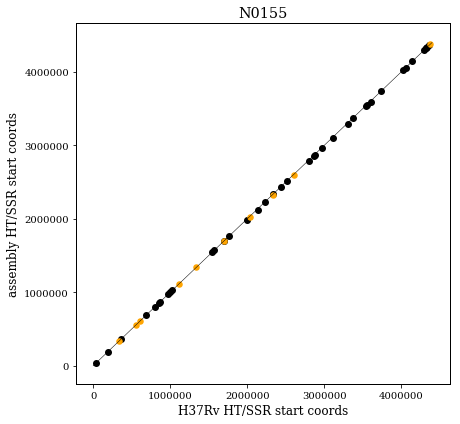

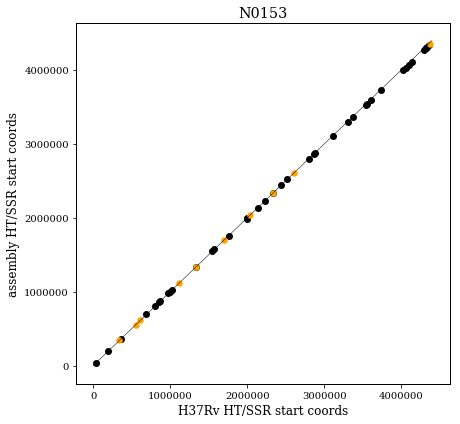

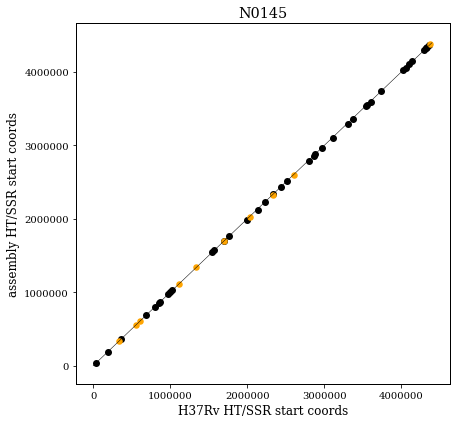

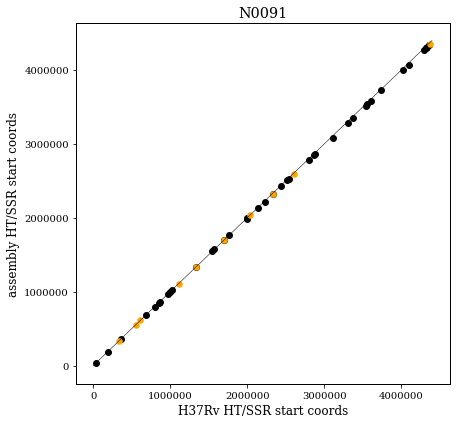

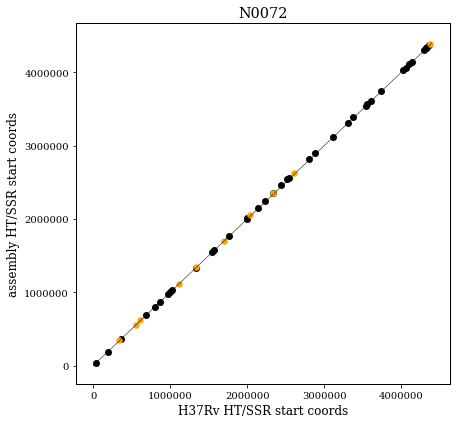

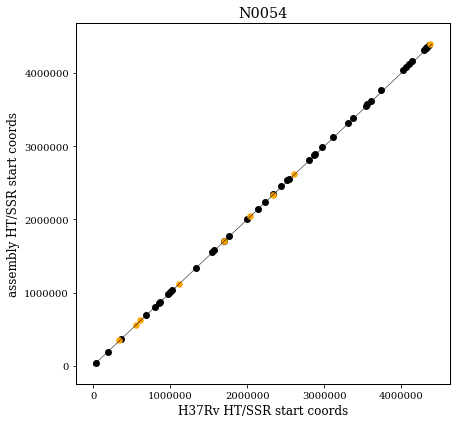

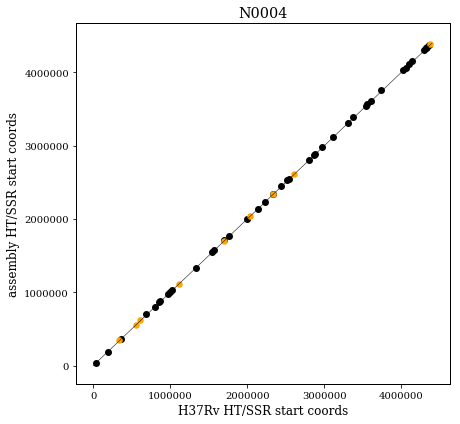

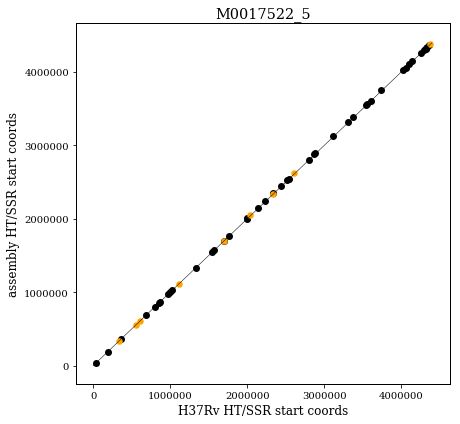

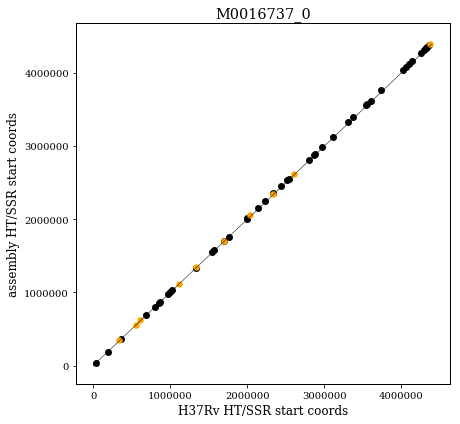

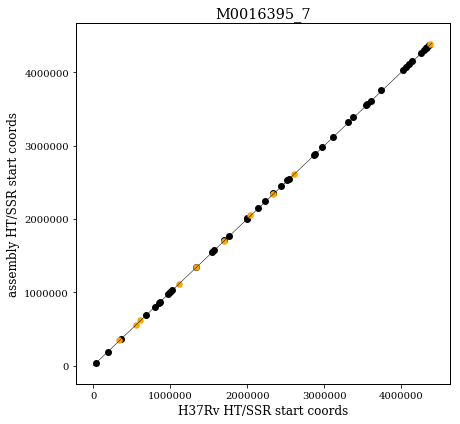

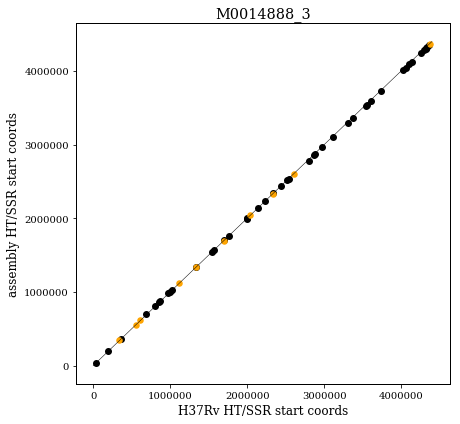

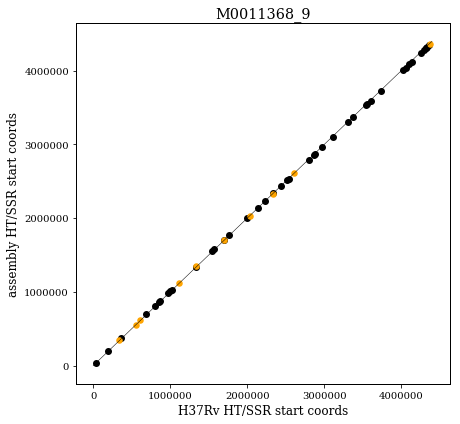

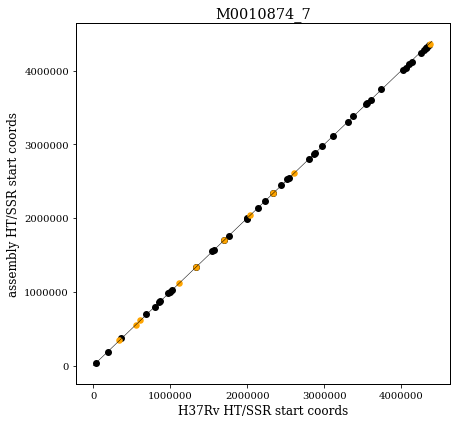

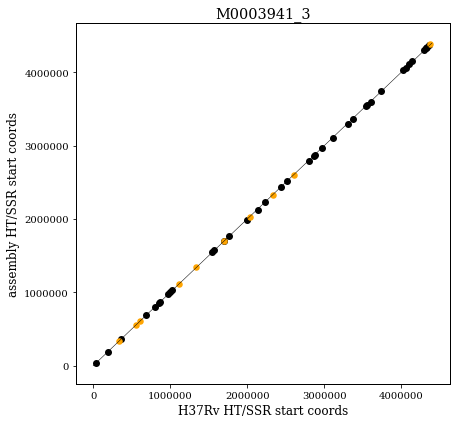

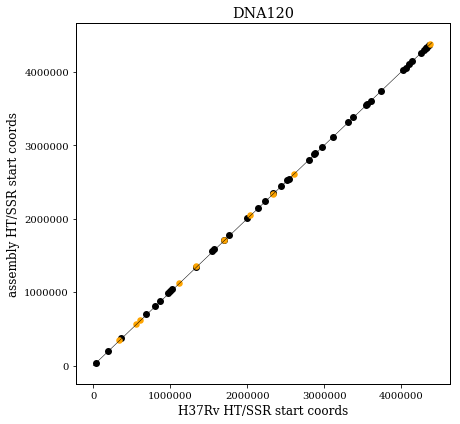

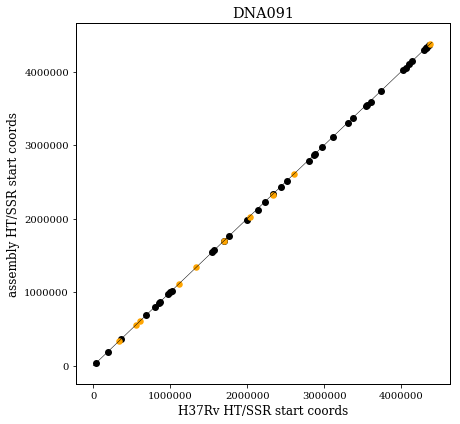

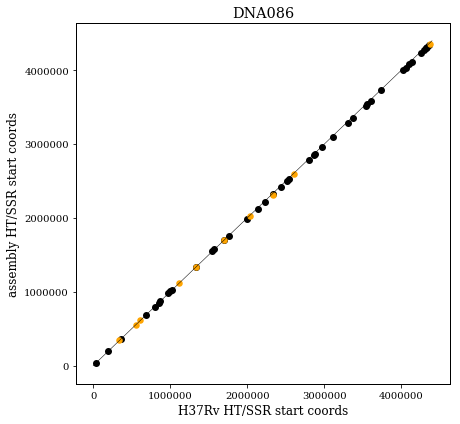

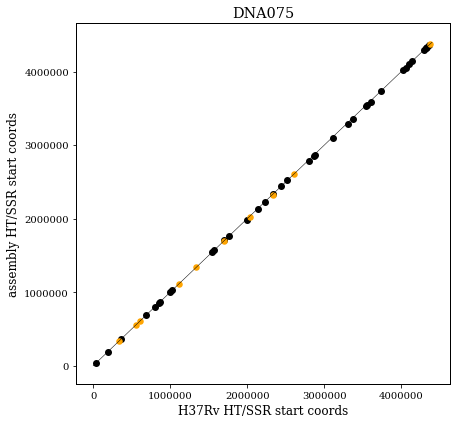

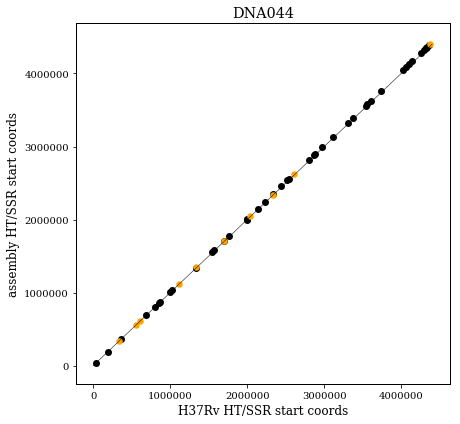

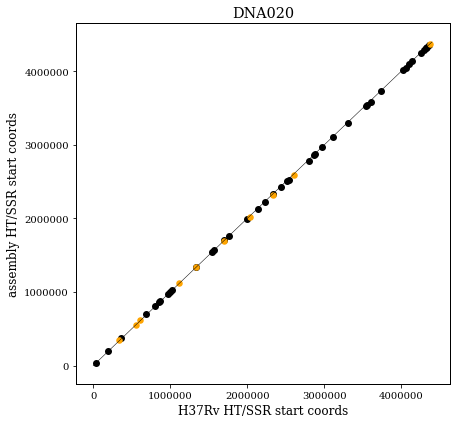

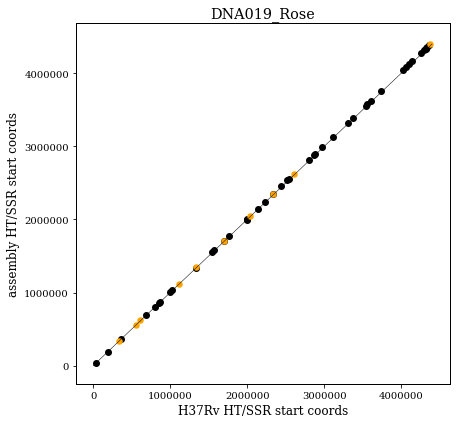

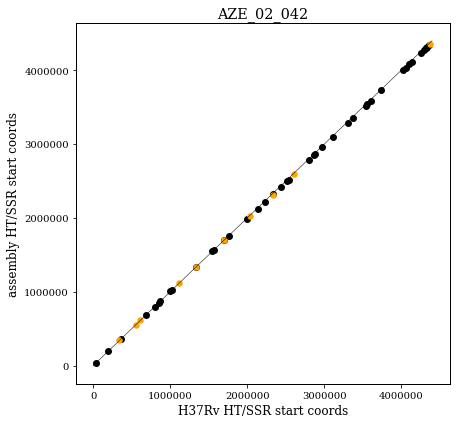

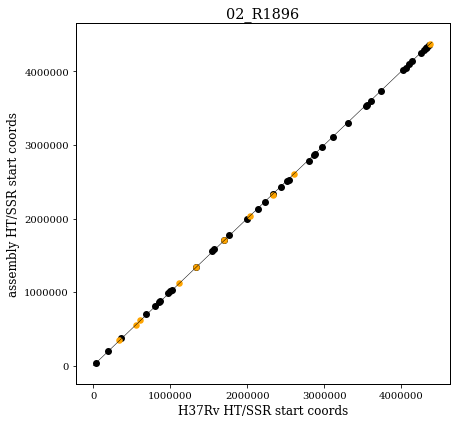

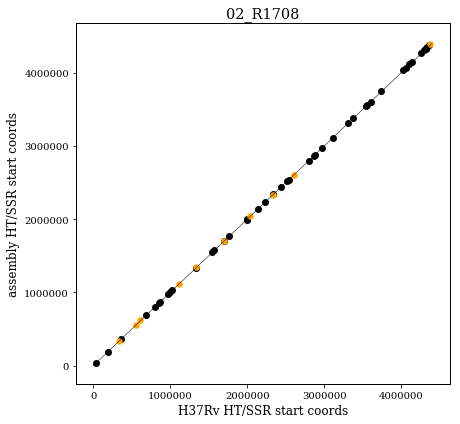

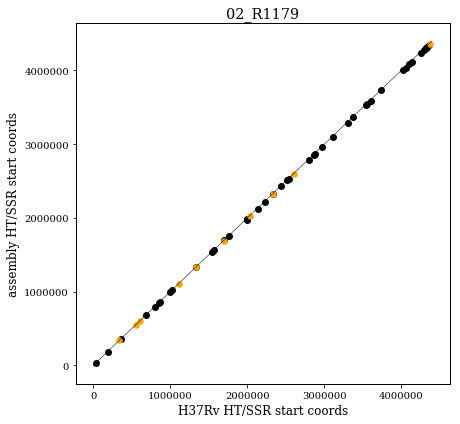

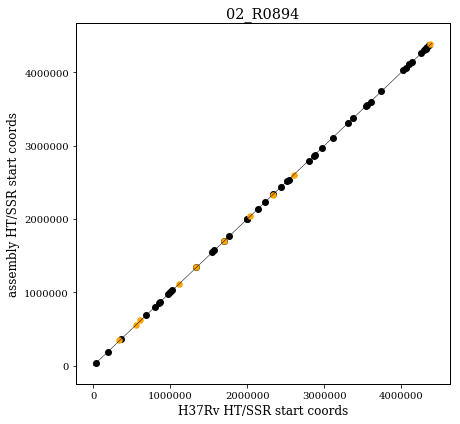

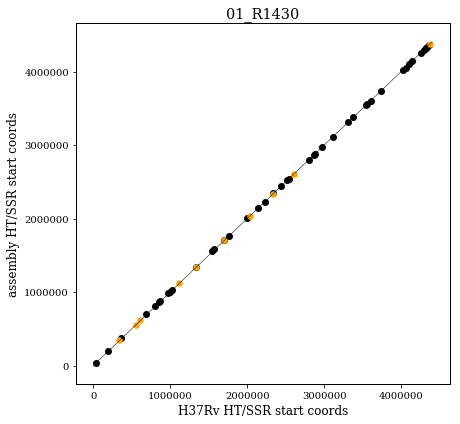

In [6]:
# keep track of maximum difference in START coords between mapped regions
max_diff_START_coords = {}

for assembly_i in genome_assemblies:
    
    fig, ax = plt.subplots()

    ax.set_title(assembly_i)
    ax.plot([0,4400000],[0,4400000], color = 'black', linewidth = 0.5)
    
    repeat_regions_df = genome_assembly_mappings_dict[assembly_i]
    
    # get rid of HT/SSR regions that did not map
    repeat_regions_df = repeat_regions_df[repeat_regions_df.assembly_polyNT != 'no match']
    
    # get rid of HT/SSR regions that mapped to multiple regions
    repeat_regions_df = repeat_regions_df[np.array([type(x) for x in repeat_regions_df.assembly_chromStart]) != list]
    
    # store the maximum difference in START coords between mapped regions for this assembly & H37Rv
    max_diff_START_coords[assembly_i] = np.max(abs(repeat_regions_df.chromStart - repeat_regions_df.assembly_chromStart))
    
    ax.scatter(repeat_regions_df[repeat_regions_df.type == 'HT'].chromStart.values, repeat_regions_df[repeat_regions_df.type == 'HT'].assembly_chromStart.values, color = 'black', alpha = 1.0, linewidth = 1.5, s = 30)
    ax.scatter(repeat_regions_df[repeat_regions_df.type == 'SSR'].chromStart.values, repeat_regions_df[repeat_regions_df.type == 'SSR'].assembly_chromStart.values, color = 'orange', alpha = 1.0, linewidth = 1.5, edgecolor = 'orange', s = 25)
    ax.set_ylabel('assembly HT/SSR start coords', color='black')
    ax.set_xlabel('H37Rv HT/SSR start coords', color='black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')

    fig = plt.gcf()
    fig.set_size_inches(6.5, 6.0)
    fig.tight_layout()
    file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/for publication/H37Rv_to_assembly_matched_region_plots/H37Rv_' + assembly_i + '_start_coord_plot.png'
    plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)
    
    plt.show()

In [115]:
max_diff_START_coords = pd.Series(max_diff_START_coords)
max_diff_START_coords.sort_values(inplace = True, ascending = False)

In [116]:
max_diff_START_coords

RW-TB008       32697.0
N1274          27604.0
N0091          26857.0
N1177          26816.0
DNA044         26811.0
N0153          24107.0
DNA019_Rose    23624.0
N0054          22396.0
N0072          22037.0
AZE_02_042     21788.0
DNA086         21616.0
N1202          20106.0
M0016737_0     19974.0
M0014888_3     19843.0
02_R1179       19270.0
N1176          18318.0
DNA091         17955.0
DNA020         17025.0
M0010874_7     16593.0
DNA075         16204.0
N0155          16180.0
N0145          16065.0
DNA120         15774.0
02_R1708       15522.0
M0003941_3     14361.0
M0011368_9     13819.0
N0004          13358.0
M0017522_5     12488.0
M0016395_7     12464.0
N1272          11124.0
02_R0894       11018.0
02_R1896       10935.0
01_R1430        7820.0
dtype: float64

####################################################################################################################################################################################

# [6] Find the difference in sequences between HT/SSR regions in H37Rv & assemblies

####################################################################################################################################################################################

In [4]:
genome_assemblies = ['RW-TB008', 'N1274', 'N1272', 'N1202', 'N1177', 'N1176', 'N0155', 
                     'N0153', 'N0145', 'N0091', 'N0072', 'N0054', 'N0004', 'M0017522_5', 
                     'M0016737_0', 'M0016395_7', 'M0014888_3', 'M0011368_9', 'M0010874_7', 
                     'M0003941_3', 'DNA120', 'DNA091', 'DNA086', 'DNA075', 'DNA044', 'DNA020', 
                     'DNA019_Rose', 'AZE_02_042', '02_R1896', '02_R1708', '02_R1179', '02_R0894', '01_R1430']

In [5]:
genome_assembly_mappings_dict = {}
for assembly_i in genome_assemblies:
    genome_assembly_mappings_dict[assembly_i] = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/HT_SSR_recall_sims/H37Rv_to_assembly_mappings_1/HT_SSR_'+assembly_i+'_mappings.pkl')

In [6]:
for assembly_i in genome_assemblies:
    
    # load HT/SSR mappings for this assembly
    repeat_regions_to_map = genome_assembly_mappings_dict[assembly_i]

    # find the difference between the regions of DNA between H37Rv & assembly w.r.t. H37Rv
    seq_diff_wrt_H37Rv = []
    for H37Rv_polyNT, H37Rv_repeat, region_type, assem_polyNT in zip(repeat_regions_to_map.polyNT, repeat_regions_to_map.repeats, repeat_regions_to_map.type, repeat_regions_to_map.assembly_polyNT):
        
        # region not mapped between assembly and H37Rv
        if assem_polyNT == 'no match':
            seq_diff = 'no match'

        elif region_type == 'HT':
            H37Rv_seq = H37Rv_polyNT
            assembly_seq = assem_polyNT

            # if seqs differ, report relative to H37Rv
            if len(H37Rv_seq) == len(assembly_seq): # same HT relative to H37Rv
                seq_diff = 'same'

            elif len(H37Rv_seq) > len(assembly_seq): # deletion relative to H37Rv
                seq_diff_bp_num = len(H37Rv_seq) - len(assembly_seq)
                seq_diff = '-' + H37Rv_seq[0]*seq_diff_bp_num

            elif len(H37Rv_seq) < len(assembly_seq): # insertion relative to H37Rv
                seq_diff_bp_num = len(assembly_seq) - len(H37Rv_seq)
                seq_diff = '+' + assembly_seq[0]*seq_diff_bp_num

        elif region_type == 'SSR':
            H37Rv_seq = H37Rv_polyNT*H37Rv_repeat
            assembly_seq = assem_polyNT

            # if seqs differ, report relative to H37Rv
            if len(H37Rv_seq) == len(assembly_seq): # same HT relative to H37Rv
                seq_diff = 'same'

            elif len(H37Rv_seq) > len(assembly_seq): # deletion relative to H37Rv
                seq_diff = '-' + H37Rv_seq[len(assembly_seq):len(H37Rv_seq)]

            elif len(H37Rv_seq) < len(assembly_seq): # insertion relative to H37Rv
                seq_diff = '+' + assembly_seq[len(H37Rv_seq):len(assembly_seq)]

        seq_diff_wrt_H37Rv.append(seq_diff)

    repeat_regions_to_map.loc[:,'seq_diff_wrt_H37Rv'] = seq_diff_wrt_H37Rv
    
    # update dataframe in dictionary
    genome_assembly_mappings_dict[assembly_i] = repeat_regions_to_map

In [7]:
# example
repeat_regions_to_map = genome_assembly_mappings_dict['N1274']

In [8]:
repeat_regions_to_map.head(n=10)

,Chromosome,INDEL_homoplasy,chromEnd,chromStart,gene_name,locus_tag,num_isolates_with_INDEL,polyNT,repeats,type,assembly_chromStart,assembly_polyNT,assembly_chromEnd,seq_diff_wrt_H37Rv
0,NC_000962.3,2317,976906,976897,PPE13,Rv0878c,8351,GGGGGGGGG,1,HT,982433.0,GGGGGGGGGG,982443.0,+G
1,NC_000962.3,776,854261,854252,inter_Rv0759c_Rv0760c,inter_Rv0759c_Rv0760c,28077,CCCCCCCCC,1,HT,859664.0,CCCCCCCC,859672.0,-C
2,NC_000962.3,578,1992331,1992323,wag22,Rv1759c,4052,CCCCCCCC,1,HT,NaN,no match,NaN,no match
3,NC_000962.3,360,2338202,2338194,Rv2081c,Rv2081c,4596,CCCCCCCC,1,HT,2365488.0,CCCCCCC,2365495.0,-C
4,NC_000962.3,282,4139190,4139183,glpK,Rv3696c,388,CCCCCCC,1,HT,4165513.0,CCCCCCCC,4165521.0,+C
5,NC_000962.3,277,1333668,1333661,Rv1190,Rv1190,914,GGGGGGG,1,HT,1339224.0,GGGGGGG,1339231.0,same
6,NC_000962.3,269,4323361,4323354,inter_Rv3848_espR,inter_Rv3848_Rv3849,1355,GGGGGGG,1,HT,4350809.0,GGGGGGG,4350816.0,same
7,NC_000962.3,217,2234254,2234247,inter_Rv1990c_mazF6,inter_Rv1990c_Rv1991c,901,GGGGGGG,1,HT,2255251.0,GGGGGGG,2255258.0,same
8,NC_000962.3,216,364505,364498,inter_vapC2_Rv0302,inter_Rv0301_Rv0302,676,GGGGGGG,1,HT,367791.0,GGGGGGG,367798.0,same
9,NC_000962.3,214,3742998,3742991,inter_PE_PGRS50_Rv3346c,inter_Rv3345c_Rv3346c,2229,GGGGGGG,1,HT,3769253.0,GGGGGGG,3769260.0,same


####################################################################################################################################################################################

# [7] Decide which variants to introduce into HT/SSR regions in different assemblies

####################################################################################################################################################################################

If the HT/SSR sequences between H37Rv and an assembly differ, then we will *not* change the sequence in the assembly. 

- if the HT sequences are the same, then we will "introduce" a +1bp insertion into the assembly sequence
- if the SSR sequences are the same, then we will "introduce" an additional unit repeat into the sequence

In [9]:
for assembly_i in genome_assemblies:
    
    # load HT/SSR mappings for this assembly
    repeat_regions_to_map = genome_assembly_mappings_dict[assembly_i]

    # find the difference between the regions of DNA between H37Rv & assembly w.r.t. H37Rv
    variants_to_introduce_assembly = []
    for H37Rv_polyNT, seq_diff, region_type in zip(repeat_regions_to_map.polyNT, repeat_regions_to_map.seq_diff_wrt_H37Rv, repeat_regions_to_map.type):
        
        # region not mapped between assembly and H37Rv
        if seq_diff == 'no match':
            variants_to_introduce_assembly.append('no match')

        elif region_type == 'HT':
            
            # check to see if seqs are different
            if seq_diff != 'same':
                variants_to_introduce_assembly.append('None')
                
            # if HT seqs are the same, introduce a +1bp insertion
            elif seq_diff == 'same':
                variants_to_introduce_assembly.append(H37Rv_polyNT[0])
                
        elif region_type == 'SSR':
            
            # check to see if seqs are different
            if seq_diff != 'same':
                variants_to_introduce_assembly.append('None')
                
            # if SSR seqs are the same, introduce a insertion that is the +repeat unit
            elif seq_diff == 'same':
                variants_to_introduce_assembly.append(H37Rv_polyNT[0])
                ## variants_to_introduce_assembly.append(H37Rv_polyNT)

    repeat_regions_to_map.loc[:,'add_seq_into_assembly'] = variants_to_introduce_assembly
    
    # update dataframe in dictionary
    genome_assembly_mappings_dict[assembly_i] = repeat_regions_to_map

In [10]:
# example
repeat_regions_to_map = genome_assembly_mappings_dict['N1274']

In [11]:
repeat_regions_to_map.head()

,Chromosome,INDEL_homoplasy,chromEnd,chromStart,gene_name,locus_tag,num_isolates_with_INDEL,polyNT,repeats,type,assembly_chromStart,assembly_polyNT,assembly_chromEnd,seq_diff_wrt_H37Rv,add_seq_into_assembly
0,NC_000962.3,2317,976906,976897,PPE13,Rv0878c,8351,GGGGGGGGG,1,HT,982433.0,GGGGGGGGGG,982443.0,+G,None
1,NC_000962.3,776,854261,854252,inter_Rv0759c_Rv0760c,inter_Rv0759c_Rv0760c,28077,CCCCCCCCC,1,HT,859664.0,CCCCCCCC,859672.0,-C,None
2,NC_000962.3,578,1992331,1992323,wag22,Rv1759c,4052,CCCCCCCC,1,HT,NaN,no match,NaN,no match,no match
3,NC_000962.3,360,2338202,2338194,Rv2081c,Rv2081c,4596,CCCCCCCC,1,HT,2365488.0,CCCCCCC,2365495.0,-C,None
4,NC_000962.3,282,4139190,4139183,glpK,Rv3696c,388,CCCCCCC,1,HT,4165513.0,CCCCCCCC,4165521.0,+C,None


#### create a column that will yield what variant *should be called* after modifying assemblies, simulating reads and mapping to H37Rv

In [12]:
for assembly_i in genome_assemblies:
    
    # load HT/SSR mappings for this assembly
    repeat_regions_to_map = genome_assembly_mappings_dict[assembly_i]

    # find the difference between the regions of DNA between H37Rv & assembly w.r.t. H37Rv
    variants_expected_called = []
    for seq_diff, seq_add in zip(repeat_regions_to_map.seq_diff_wrt_H37Rv, repeat_regions_to_map.add_seq_into_assembly):
        
        if seq_diff == 'no match':
            variants_expected_called.append('no match')
            
        elif seq_diff == 'same':
            variants_expected_called.append('+' + seq_add)
        
        else:
            variants_expected_called.append(seq_diff)
                
    repeat_regions_to_map.loc[:,'expected_variant_call'] = variants_expected_called
    
    # update dataframe in dictionary
    genome_assembly_mappings_dict[assembly_i] = repeat_regions_to_map

In [13]:
repeat_regions_to_map = genome_assembly_mappings_dict['N1274']

In [14]:
repeat_regions_to_map.head(n=20)

,Chromosome,INDEL_homoplasy,chromEnd,chromStart,gene_name,locus_tag,num_isolates_with_INDEL,polyNT,repeats,type,assembly_chromStart,assembly_polyNT,assembly_chromEnd,seq_diff_wrt_H37Rv,add_seq_into_assembly,expected_variant_call
0,NC_000962.3,2317,976906,976897,PPE13,Rv0878c,8351,GGGGGGGGG,1,HT,982433.0,GGGGGGGGGG,982443.0,+G,None,+G
1,NC_000962.3,776,854261,854252,inter_Rv0759c_Rv0760c,inter_Rv0759c_Rv0760c,28077,CCCCCCCCC,1,HT,859664.0,CCCCCCCC,859672.0,-C,None,-C
2,NC_000962.3,578,1992331,1992323,wag22,Rv1759c,4052,CCCCCCCC,1,HT,NaN,no match,NaN,no match,no match,no match
3,NC_000962.3,360,2338202,2338194,Rv2081c,Rv2081c,4596,CCCCCCCC,1,HT,2365488.0,CCCCCCC,2365495.0,-C,None,-C
4,NC_000962.3,282,4139190,4139183,glpK,Rv3696c,388,CCCCCCC,1,HT,4165513.0,CCCCCCCC,4165521.0,+C,None,+C
5,NC_000962.3,277,1333668,1333661,Rv1190,Rv1190,914,GGGGGGG,1,HT,1339224.0,GGGGGGG,1339231.0,same,G,+G
6,NC_000962.3,269,4323361,4323354,inter_Rv3848_espR,inter_Rv3848_Rv3849,1355,GGGGGGG,1,HT,4350809.0,GGGGGGG,4350816.0,same,G,+G
7,NC_000962.3,217,2234254,2234247,inter_Rv1990c_mazF6,inter_Rv1990c_Rv1991c,901,GGGGGGG,1,HT,2255251.0,GGGGGGG,2255258.0,same,G,+G
8,NC_000962.3,216,364505,364498,inter_vapC2_Rv0302,inter_Rv0301_Rv0302,676,GGGGGGG,1,HT,367791.0,GGGGGGG,367798.0,same,G,+G
9,NC_000962.3,214,3742998,3742991,inter_PE_PGRS50_Rv3346c,inter_Rv3345c_Rv3346c,2229,GGGGGGG,1,HT,3769253.0,GGGGGGG,3769260.0,same,G,+G


save as a pickled dataframe

In [15]:
for assembly_i in genome_assemblies:
    
    # load HT/SSR mappings for this assembly
    repeat_regions_to_map = genome_assembly_mappings_dict[assembly_i]
    repeat_regions_to_map.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/HT_SSR_recall_sims/H37Rv_to_assembly_mappings_2/HT_SSR_'+assembly_i+'_mappings.pkl')